In [628]:
# imports
# Required libraries to be installed: Pillow, OpenCV
import cv2 as cv
import numpy as np
import glob
import os
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display
import PIL.Image
import io

In [629]:
# helper functions
def show_image(a, fmt='jpeg'):
    if(len(a.shape)) == 3:
        a = cv.cvtColor(a, cv.COLOR_BGR2RGB)
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def read_image(index, source, resize):
    image = cv.imread(source[index])
    return cv.resize(image, (0, 0), fx=resize, fy=resize)

In [630]:
# I tried with multiple images in the beginning
task1 = glob.glob(os.path.join('./', "training_data/Task1/*.jpg")) 
task2 = glob.glob(os.path.join('./', "training_data/Task2/*.mp4")) 
task3 = glob.glob(os.path.join('./', "training_data/Task3/*.mp4")) 
task4 = glob.glob(os.path.join('./', "training_data/Task4/*.mp4")) 
task2_modified = glob.glob(os.path.join('./', "Modified/Task2/*.mp4")) 
# print(task1_images)

In [631]:
# This function takes the video path and returns the a list of frames.
def read_frames(video_path, only_table=True):
    frames = []
    cap = cv.VideoCapture(video_path)  
    if cap.isOpened() == False: 
        print("Error opening video stream or file") 
        return frames
    
    while cap.isOpened():  
        ret, frame = cap.read() # Read the frame
        if ret is True:
            if (only_table):
                frames.append(find_table(frame))
            else:
                frames.append(frame)
        else:
            break
    cap.release()
    return frames

In [632]:
def find_table(frame, show_results=True):
    low_green = (55, 145, 50)
    high_green = (75, 255, 255)
    frame_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    # get the mask for green
    mask_table_hsv = cv.inRange(frame_hsv, low_green, high_green)

    kernel = np.ones((15, 15), np.uint8)
    mask_table_hsv = cv.dilate(mask_table_hsv, kernel, iterations=2)
    mask_table_hsv = cv.erode(mask_table_hsv, kernel, iterations=2)
       
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(mask_table_hsv, connectivity=4)    
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    connected_component = np.zeros(output.shape)
    connected_component[output == max_label] = 255
    #     show_image(connected_component)
    connected_component = connected_component.astype(np.int8)
    table = cv.bitwise_and(frame, frame, mask=connected_component)  

    table = cv.bitwise_and(frame, frame, mask=mask_table_hsv)  
    contours, hierarchy = cv.findContours(mask_table_hsv, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    max_area = 0        
    img_contour = np.zeros(table.shape, np.uint8)

    # take the largest in area contour
    if len(contours) > 0:
        cnt = contours[0]
        for i, cont in enumerate(contours):   
            contour_area = cv.contourArea(cont)            
            if contour_area > max_area:
                max_area = contour_area
                cnt = contours[i]     

        epsilon = 0.005 * cv.arcLength(cnt, True) # contour perimeter
        approx = cv.approxPolyDP(cnt, epsilon, True) # get the approximation
#         print(approx)
        hull = cv.convexHull(cnt)
    
        cv.drawContours(table, [approx], 0, (255, 255, 255), -1)
        table_mask = cv.inRange(table, (255, 255, 255), (255, 255, 255))
#         show_image(table_mask)
        table2 = cv.bitwise_and(frame, frame, mask=table_mask)  
    
        topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
        
        x1 = 9999
        y1 = 100
        
        x2 = 0
        y2 = 0
        
        x3 = 99999
        y3 = 0
        
        x4 = 0
        y4 = 0
        
        for i in cnt:
            # 1 - topleft
            if (i[0][1] < (topmost[1] + 10)):
                if (i[0][0] < x1):
                    x1 = i[0][0]
                    y1 = i[0][1]
            
            # 2 - top right
            if (i[0][1] < (topmost[1] + 10)):
                if (i[0][0] > x2):
                    x2 = i[0][0]
                    y2 = i[0][1]
            
            # 3 - bottom left
            if (i[0][0] < x3):
                x3 = i[0][0]
                y3 = i[0][1]
            
            # 4 - bottom right
            if (i[0][0] > x4):
                x4 = i[0][0]
                y4 = i[0][1]
            ### another way to take p3 and p4 that works even with people. Must make sure table is extracted correctly
#             # 3 - bottom left
#             if (i[0][0] < x3):
#                 x3 = i[0][0]
                
#             if (i[0][1] > y3):
#                 y3 = i[0][1]
            
#             # 4 - bottom right
#             if (i[0][0] > x4):
#                 x4 = i[0][0]
#             if (i[0][1] > y4):
#                 y4 = i[0][1]
            
        #middle 
        x_mid, y_mid = line_intersection(((x1, y1), (x4, y4)), ((x2, y2), (x3, y3)))
        # 5 - middle left
        x5, y5 = line_intersection(((0, y_mid), (table.shape[1], y_mid)), ((x1, y1), (x3, y3)))
        # 6 - middle right
        x6, y6 = line_intersection(((0, y_mid), (table.shape[1], y_mid)), ((x2, y2), (x4, y4)))
                
        
#         for point in approx:
#             cv.circle(table2,(approx[0][0][0], approx[0][0][1]),10,(255,0,0),2)
        cv.circle(table2,(x1, y1),10,(255,255,255),2)
        cv.circle(table2,(x2, y2),10,(0,255,255),2)
        cv.circle(table2,(x3, y3),10,(0,255,0),2)
        cv.circle(table2,(x4, y4),10,(255,255,255),2)
        cv.circle(table2,(x5, y5),10,(255,0,255),2)
        cv.circle(table2,(x6, y6),10,(255,0,255),2)
#         cv.circle(table2,(x_mid, y_mid),10,(255,0,255),2)
        
#         line1 = cv.line(table2, (x1, y1), (x4, y4), (255, 255, 255), 2)
#         line2 = cv.line(table2, (x2, y2), (x3, y3), (255, 255, 255), 2)
#         line3 = cv.line(table2, (0, y_mid), (table.shape[1], y_mid), (255, 255, 255), 2)
        
#         cv.line(table2, (x1, y1), (x3, y3), (0, 255, 255), 2)        
#         cv.line(table2, (x2, y2), (x4, y4), (0, 255, 255), 2)
    return table2

In [633]:
### TAKEN FROM STACKOVERFLOW: 
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x.astype(np.int16), y.astype(np.int16)


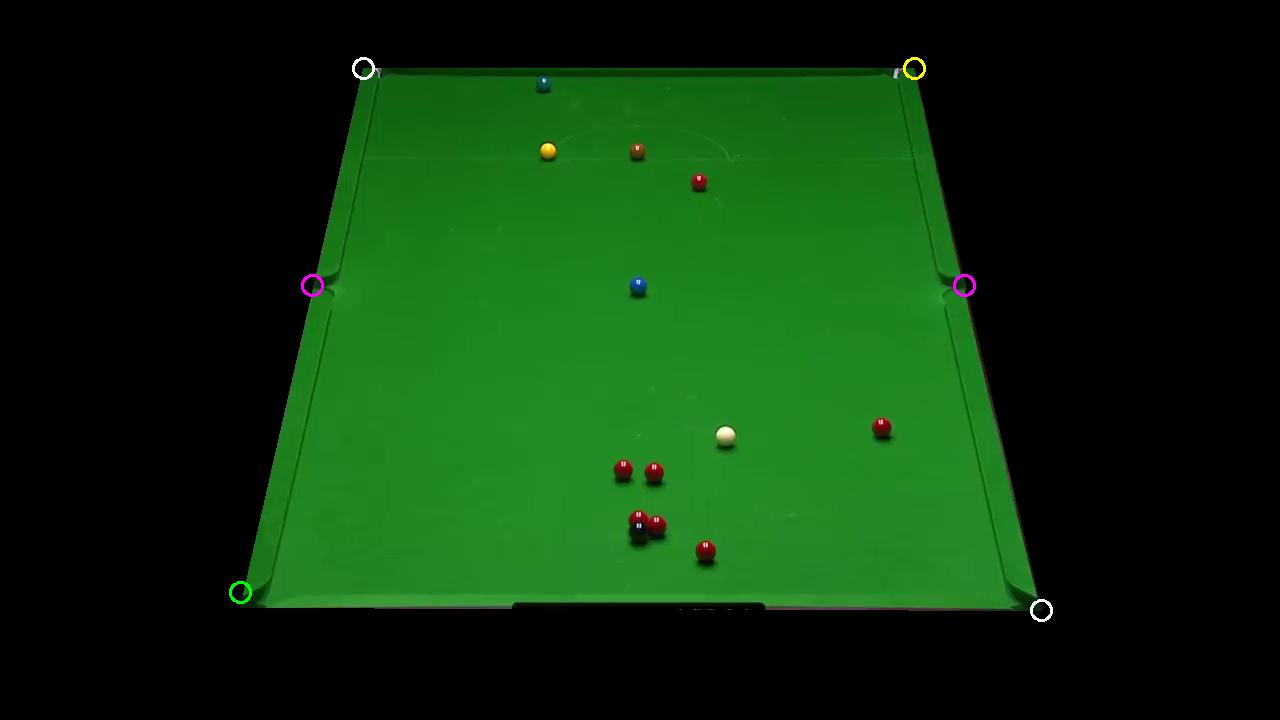

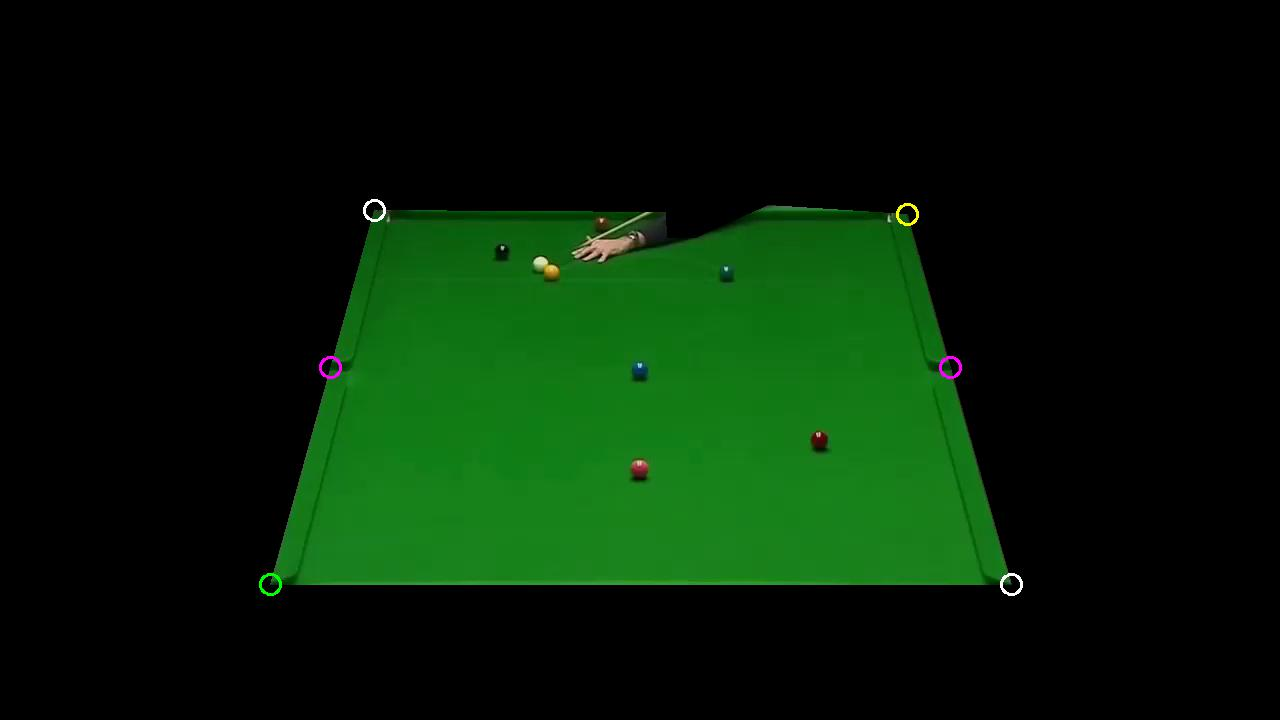

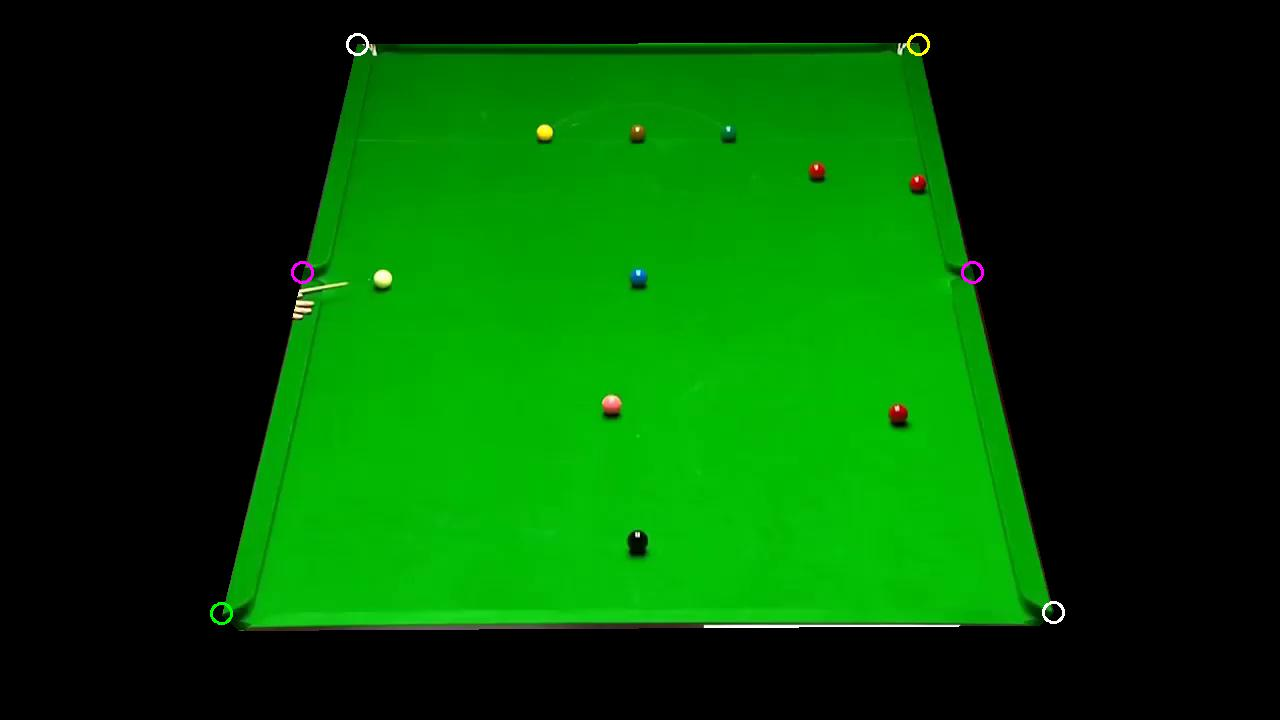

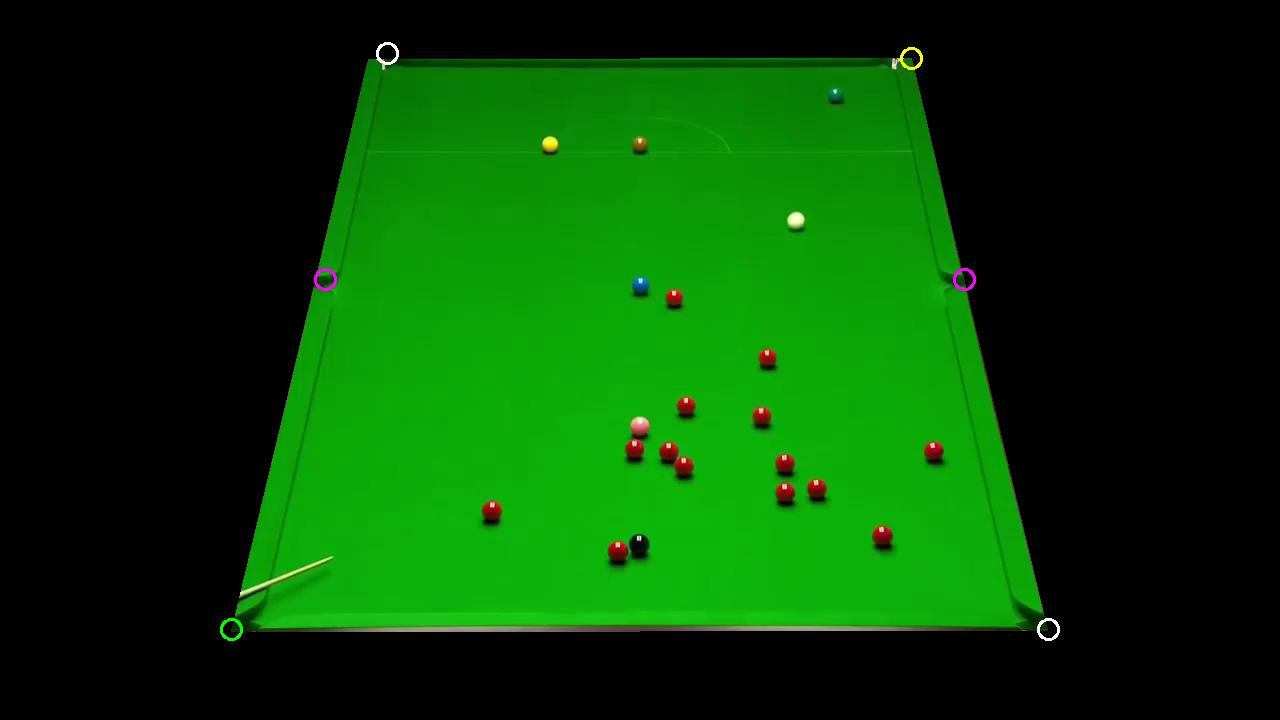

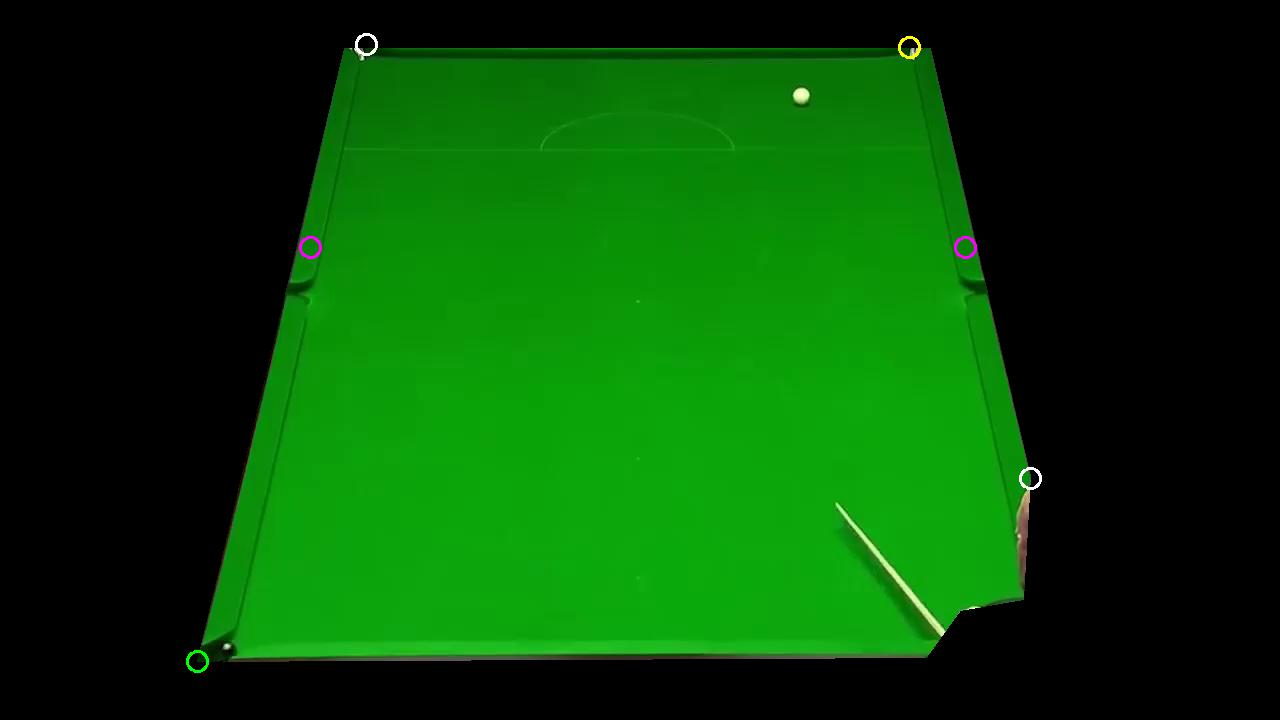

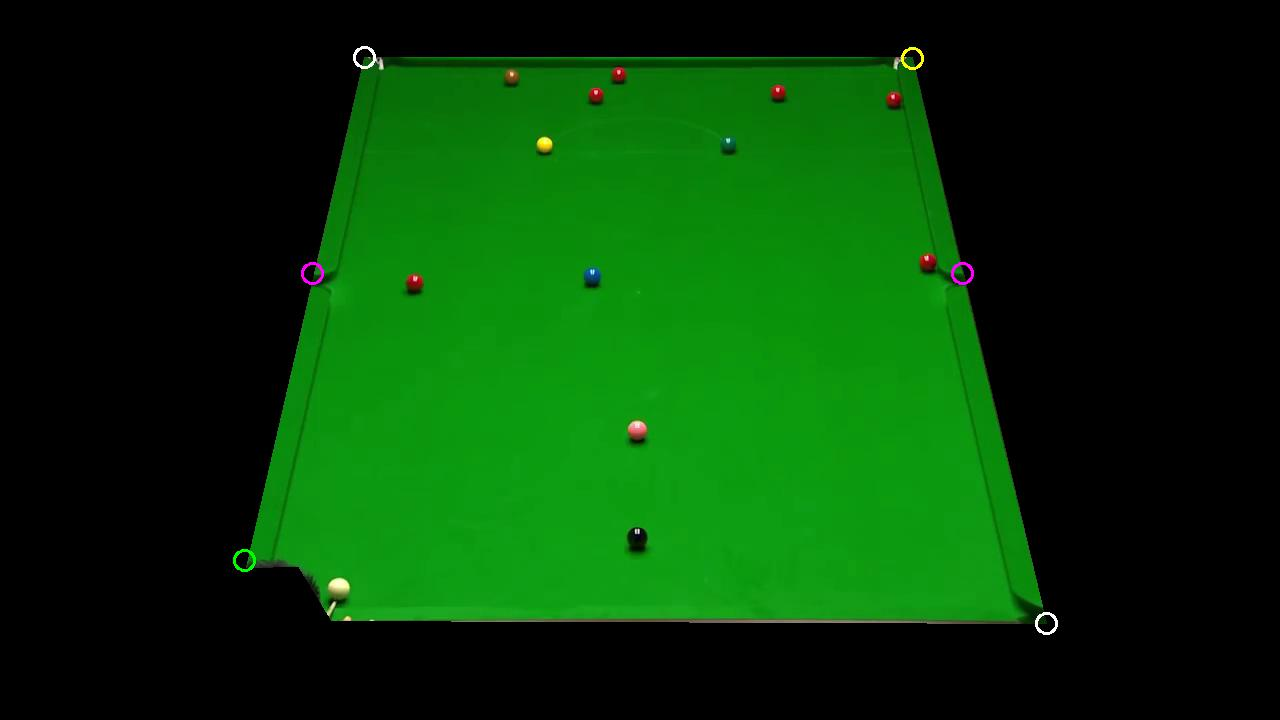

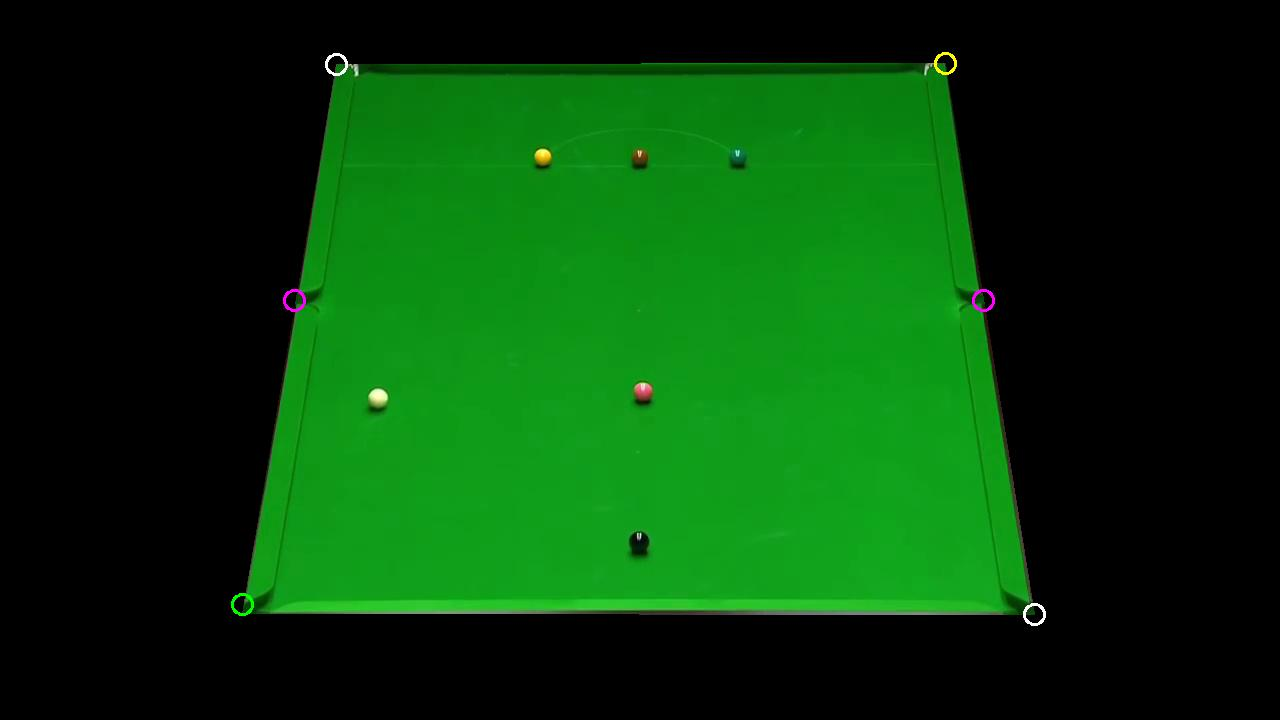

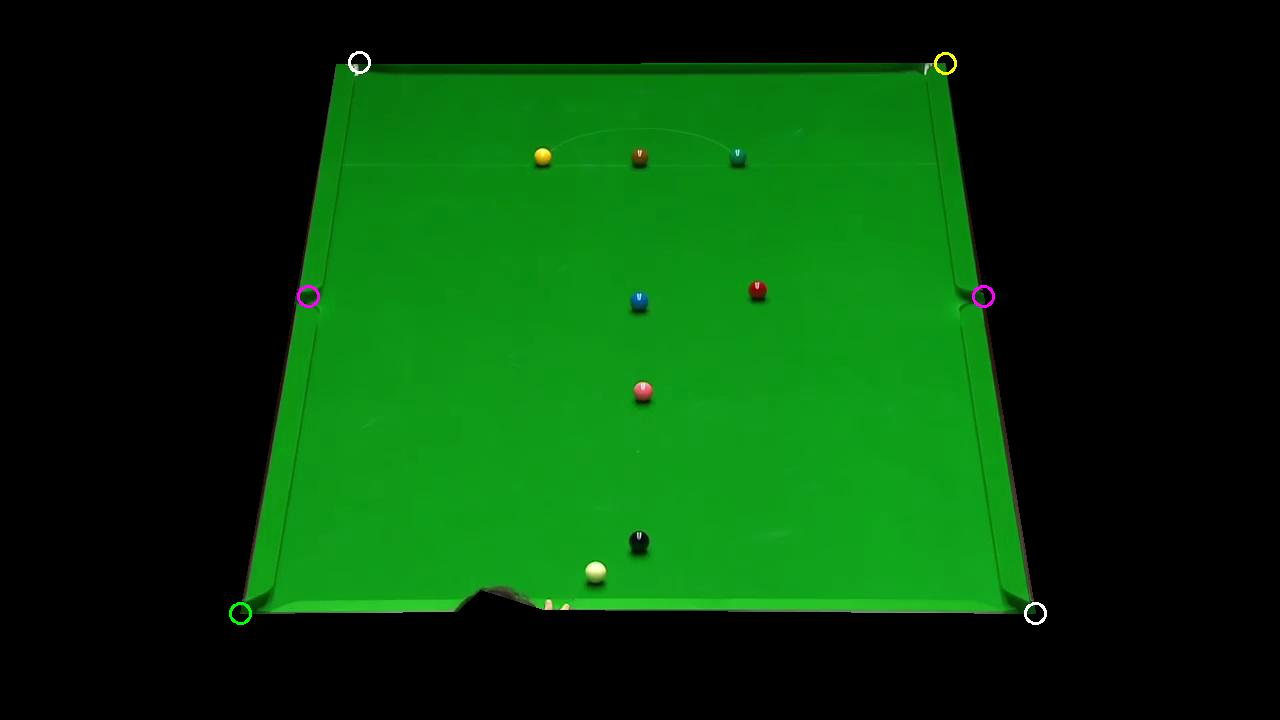

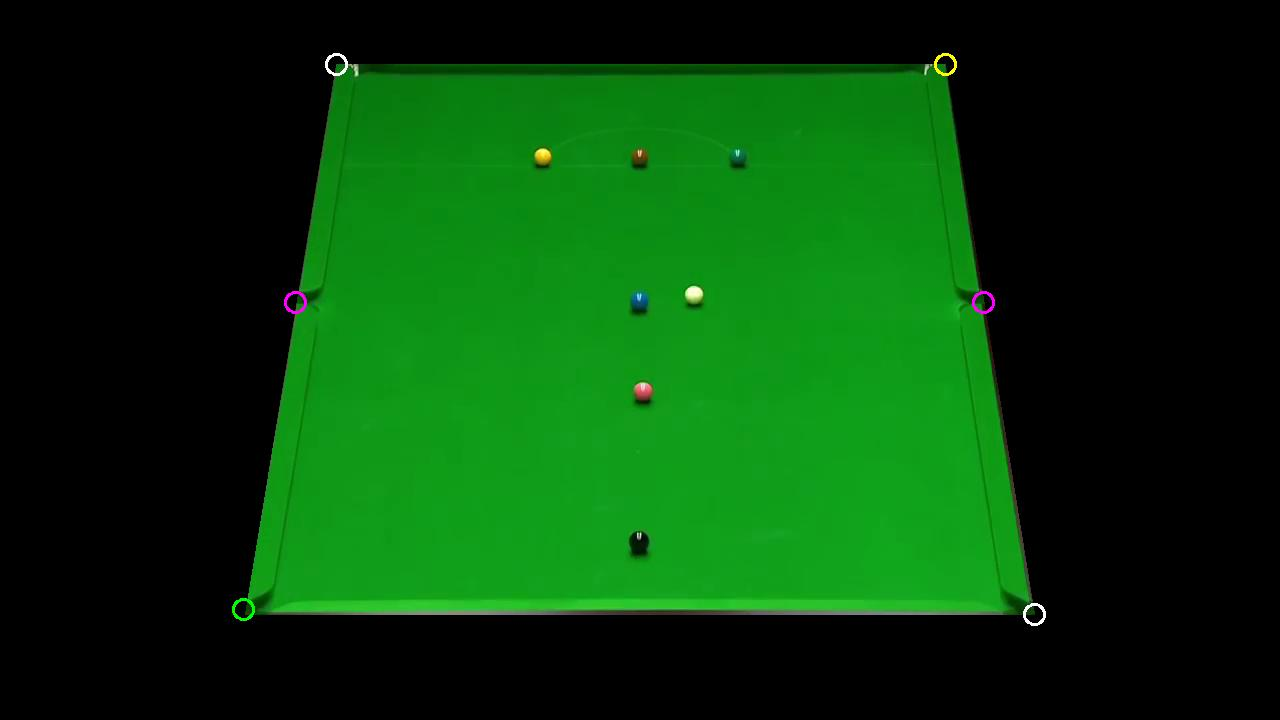

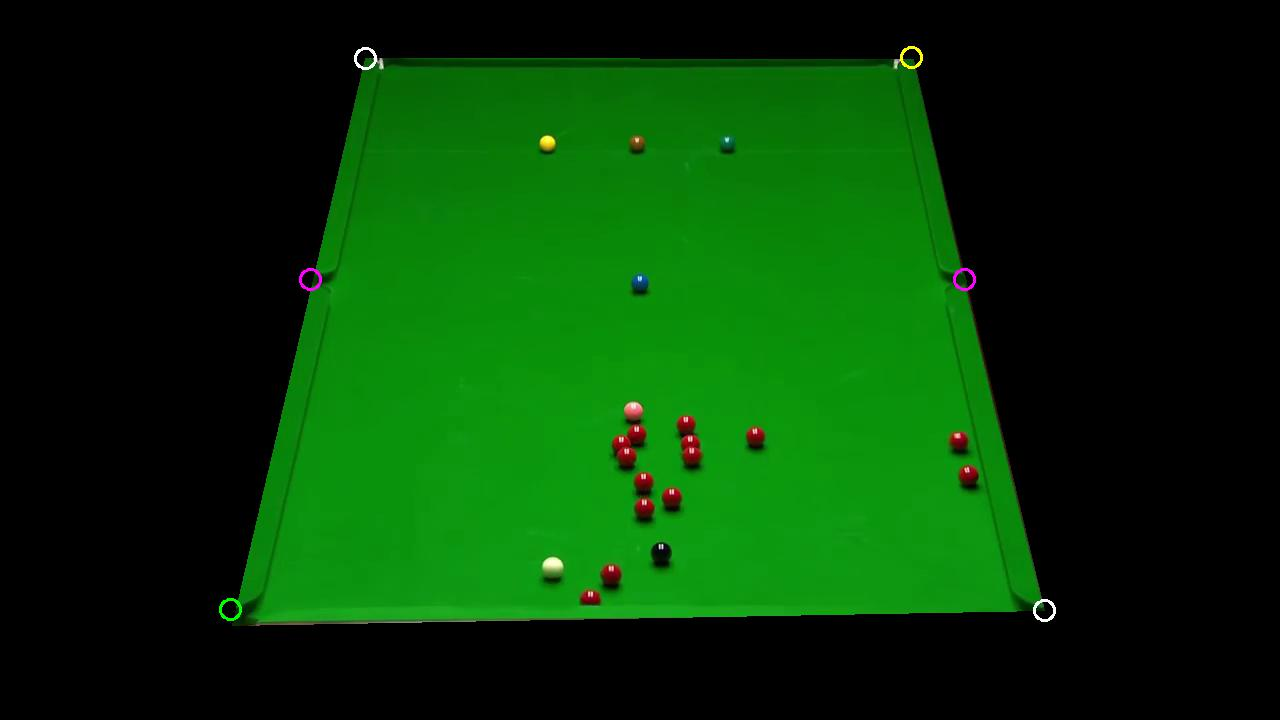

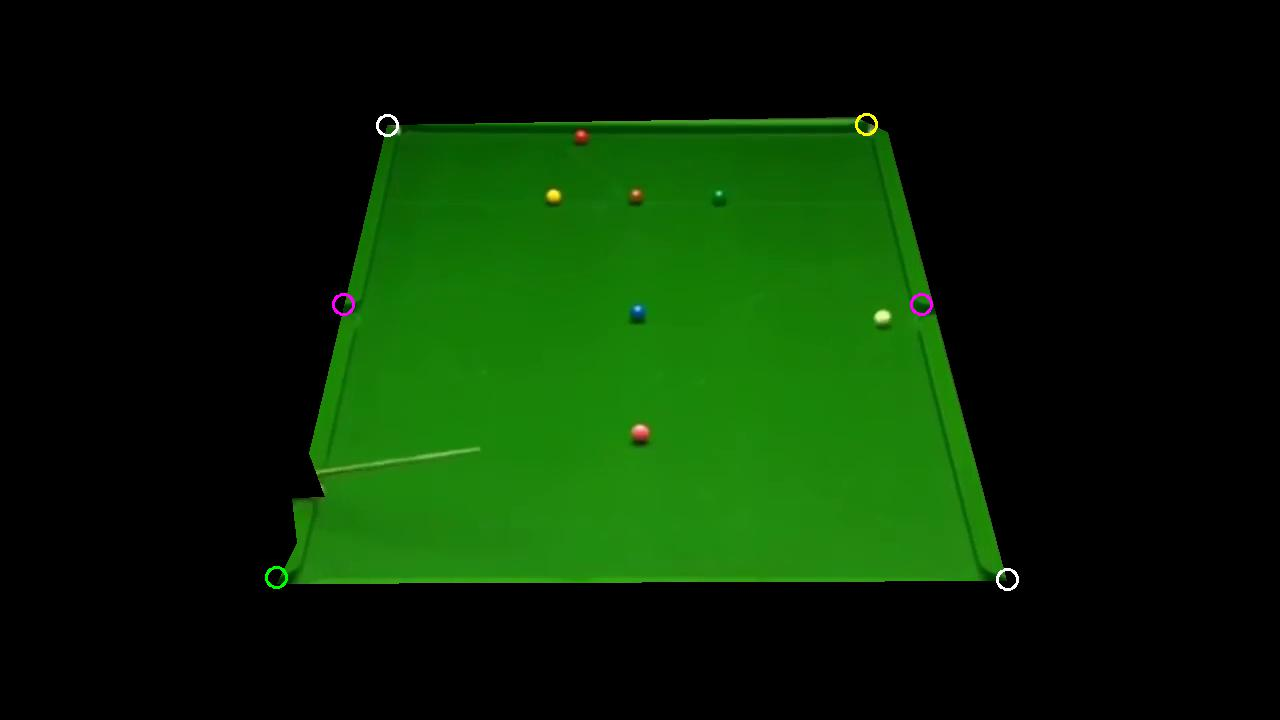

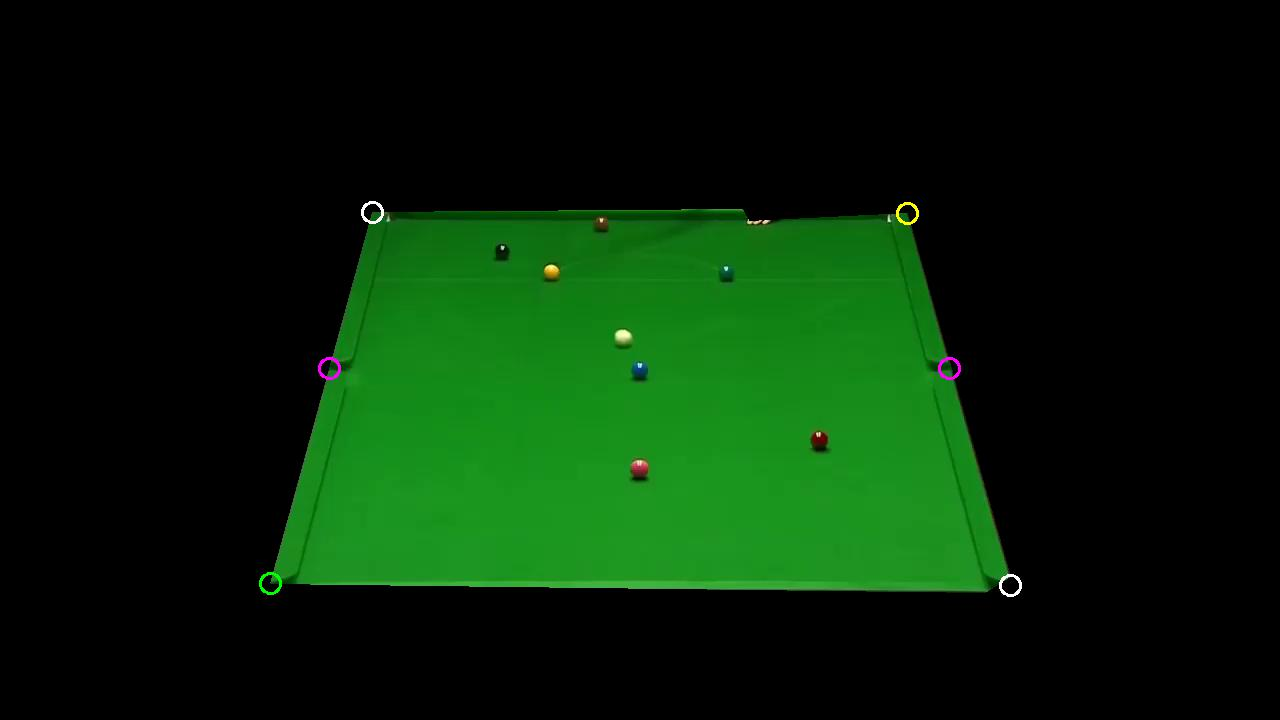

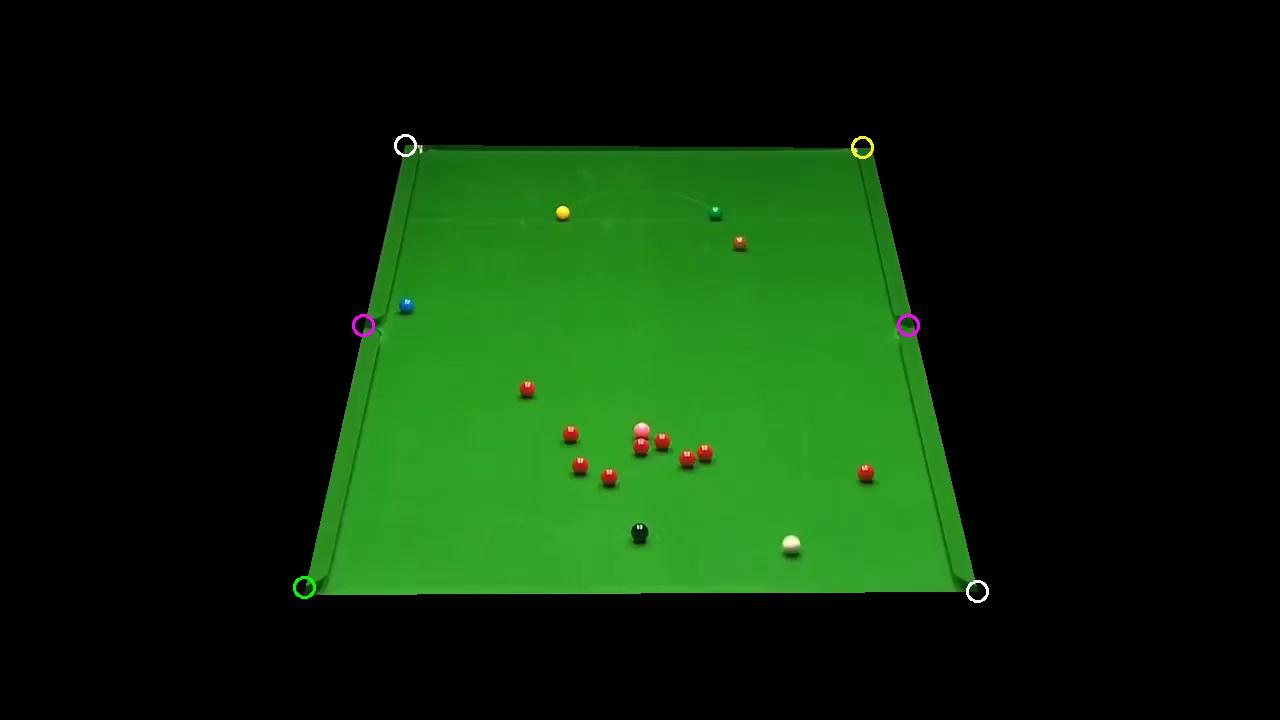

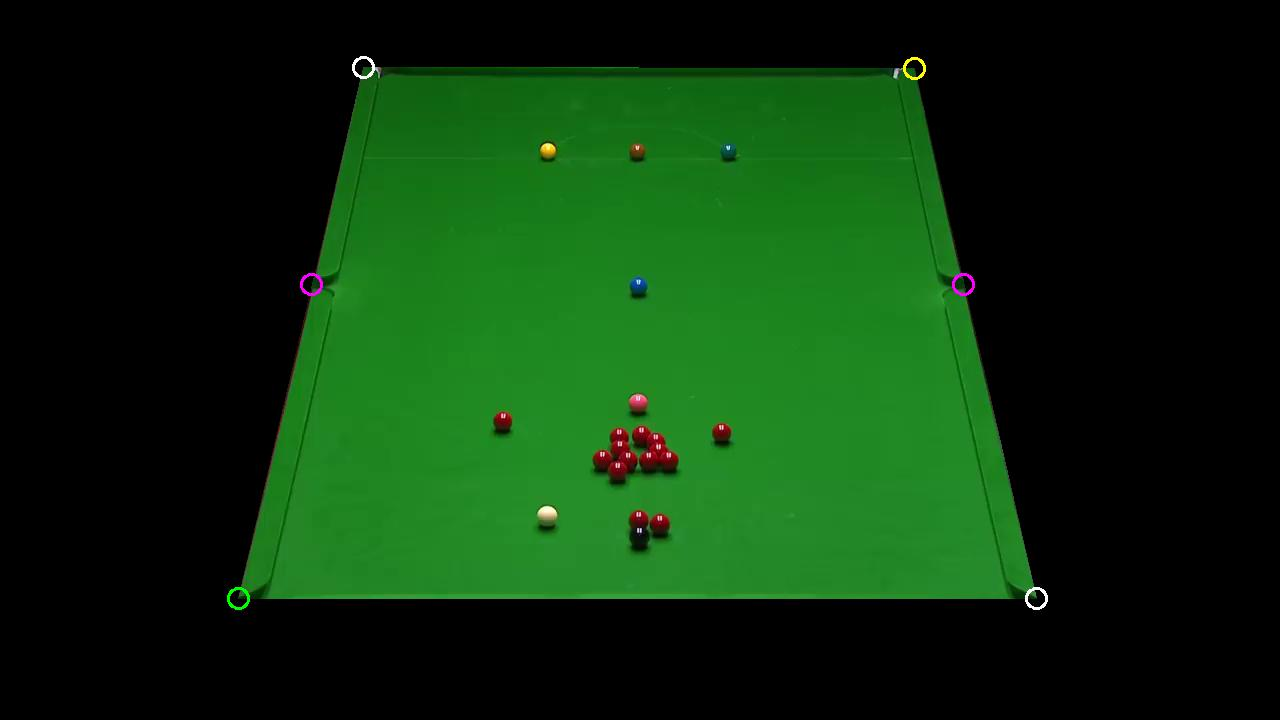

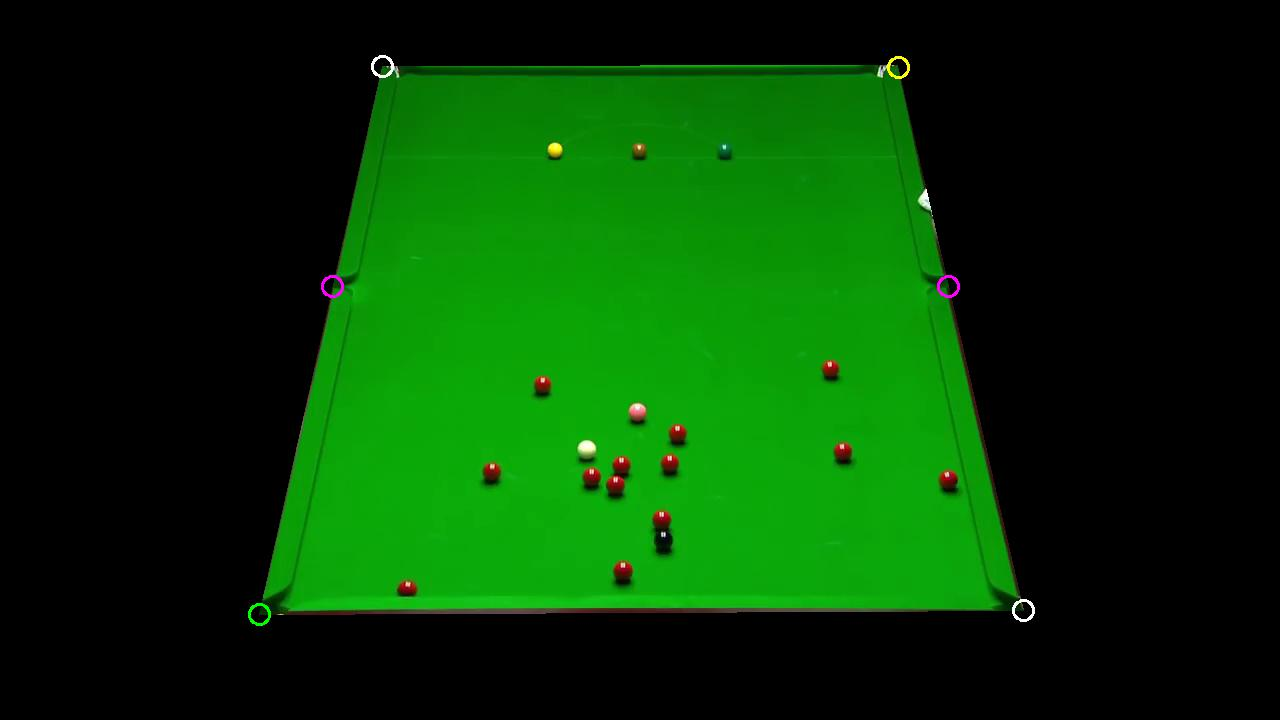

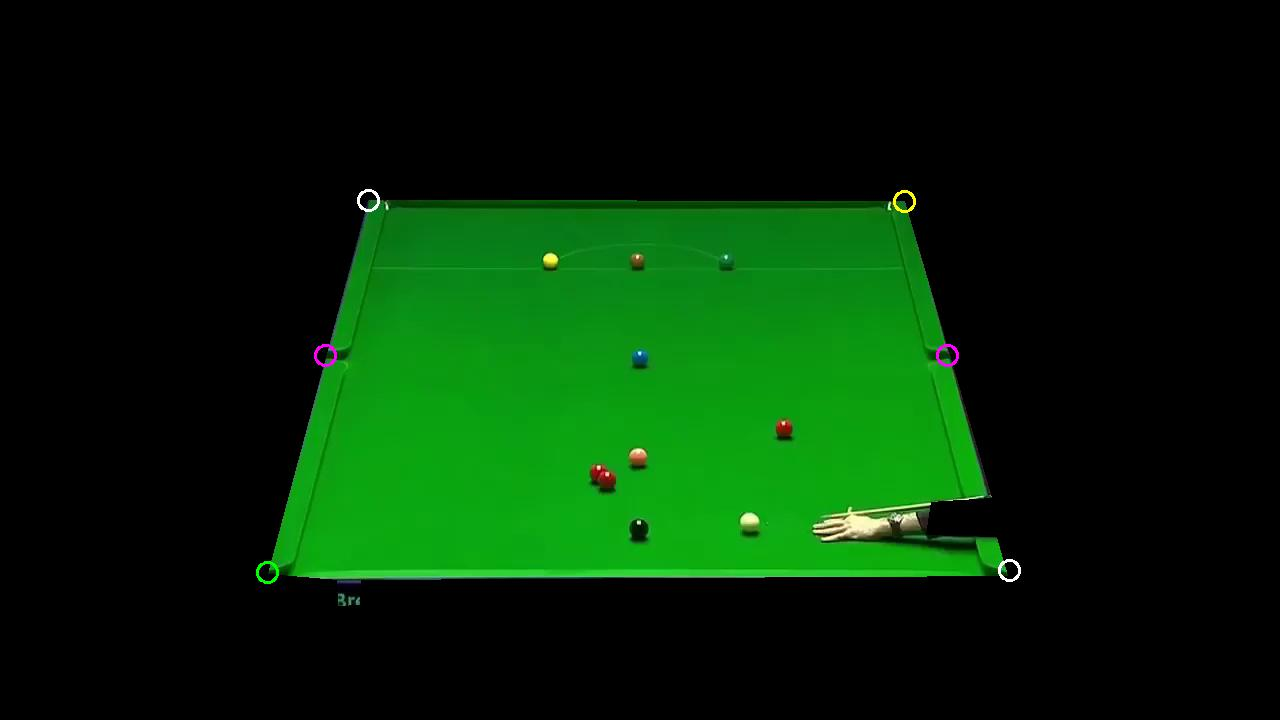

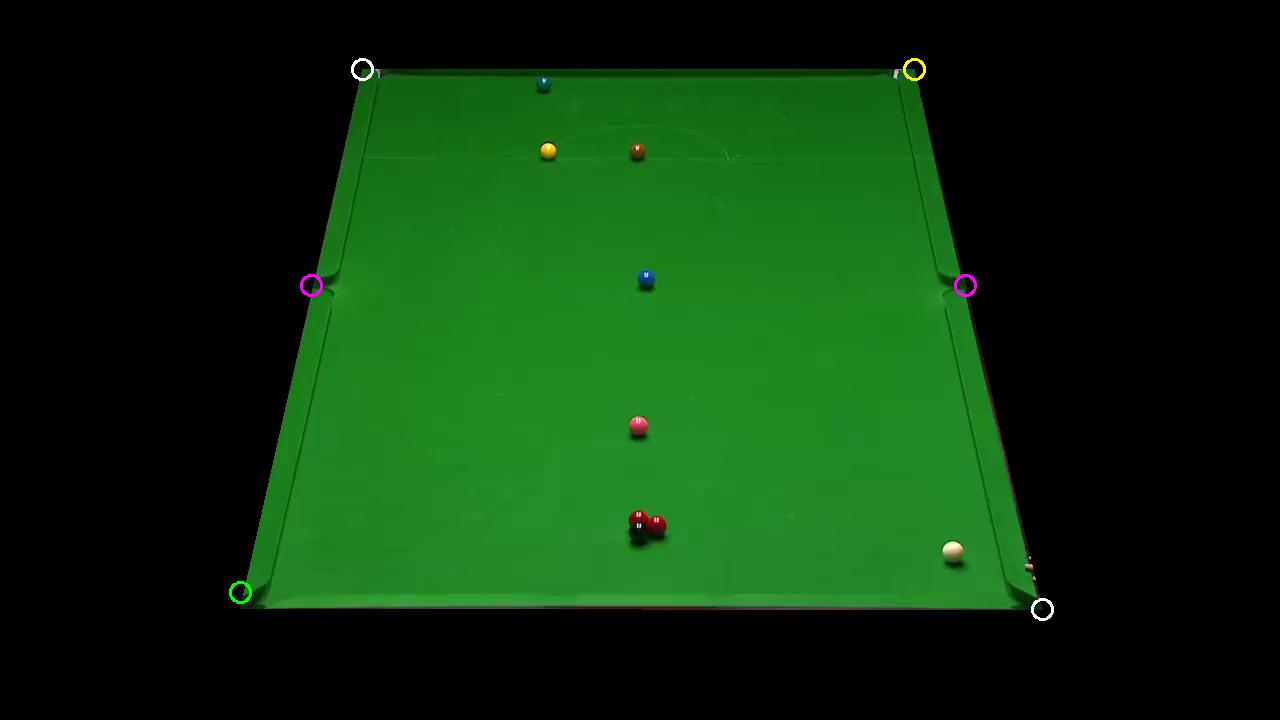

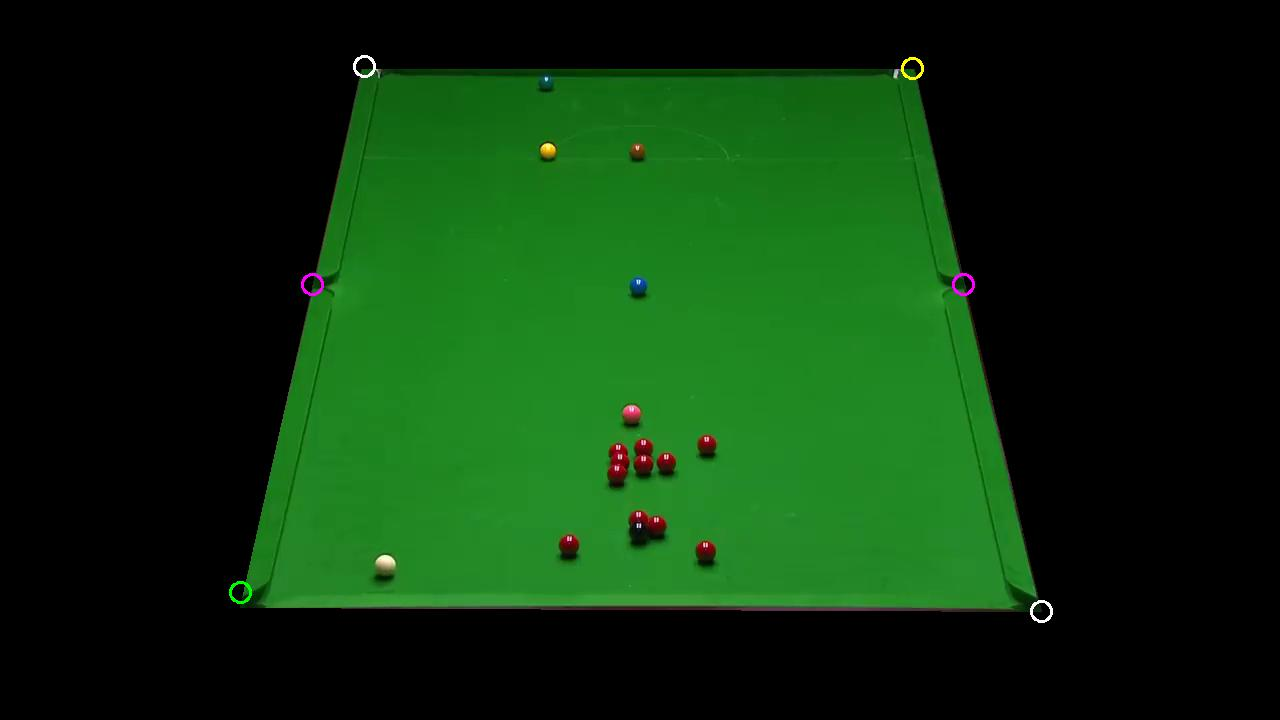

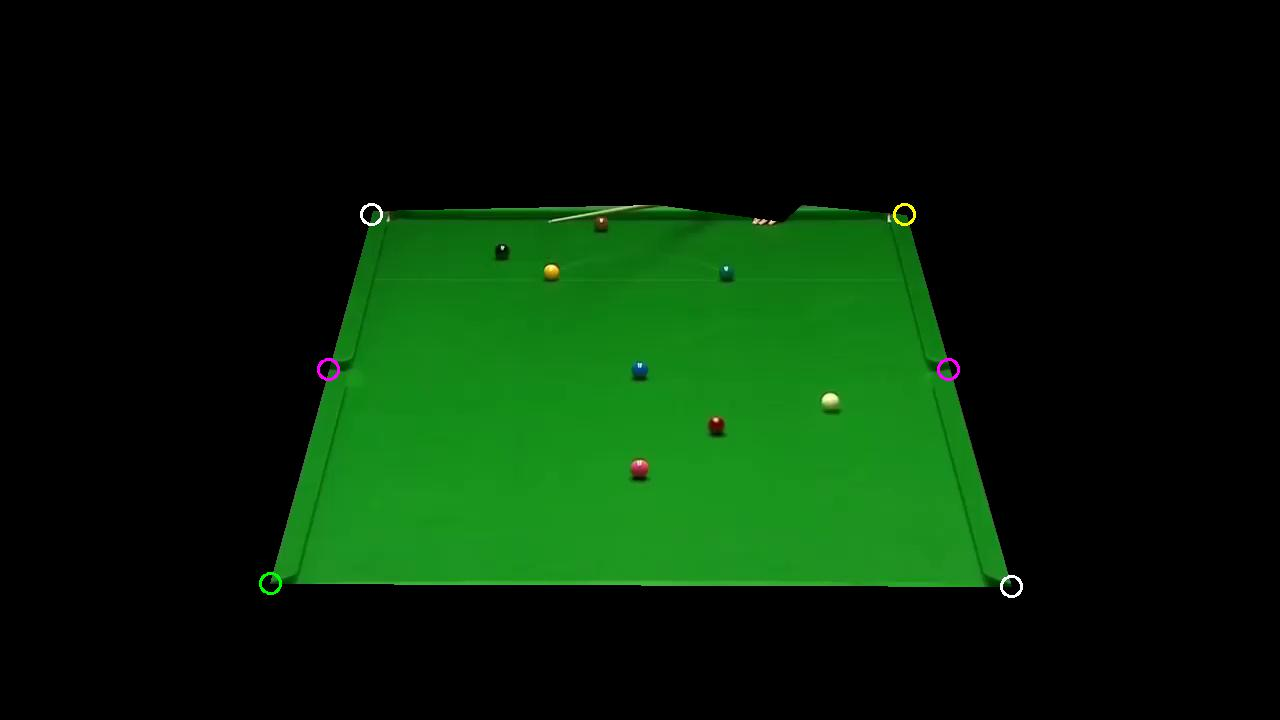

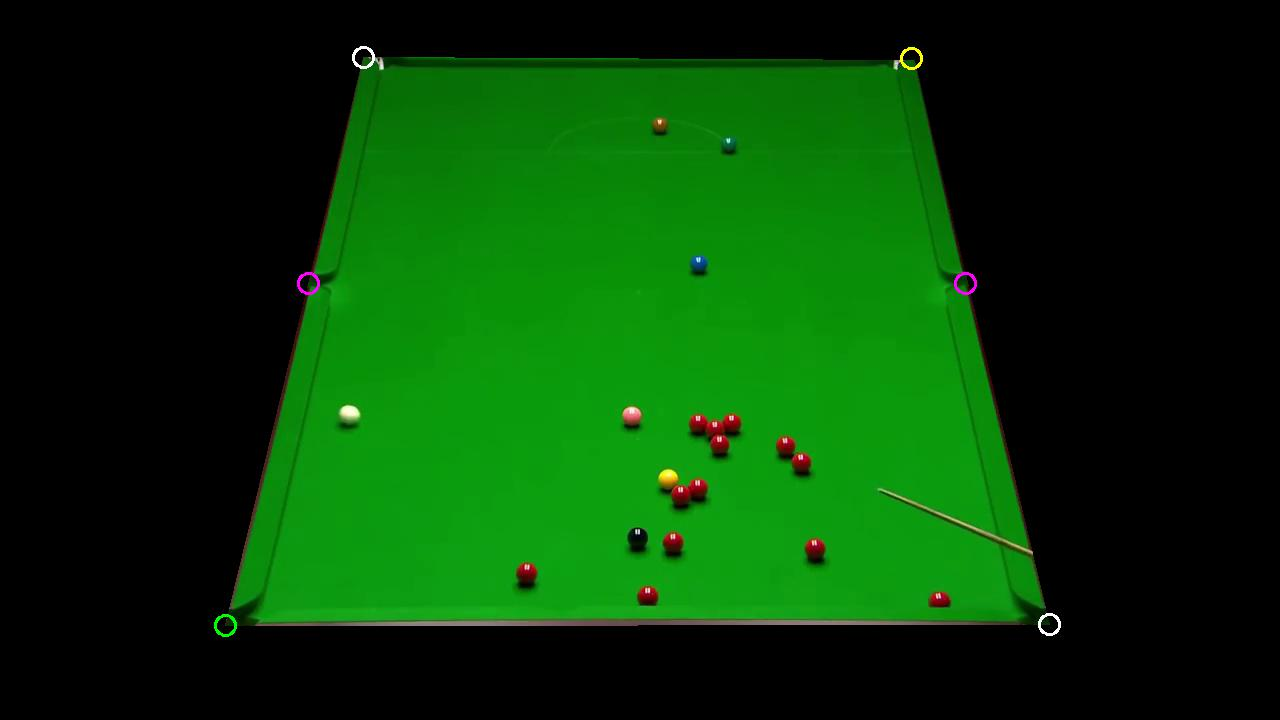

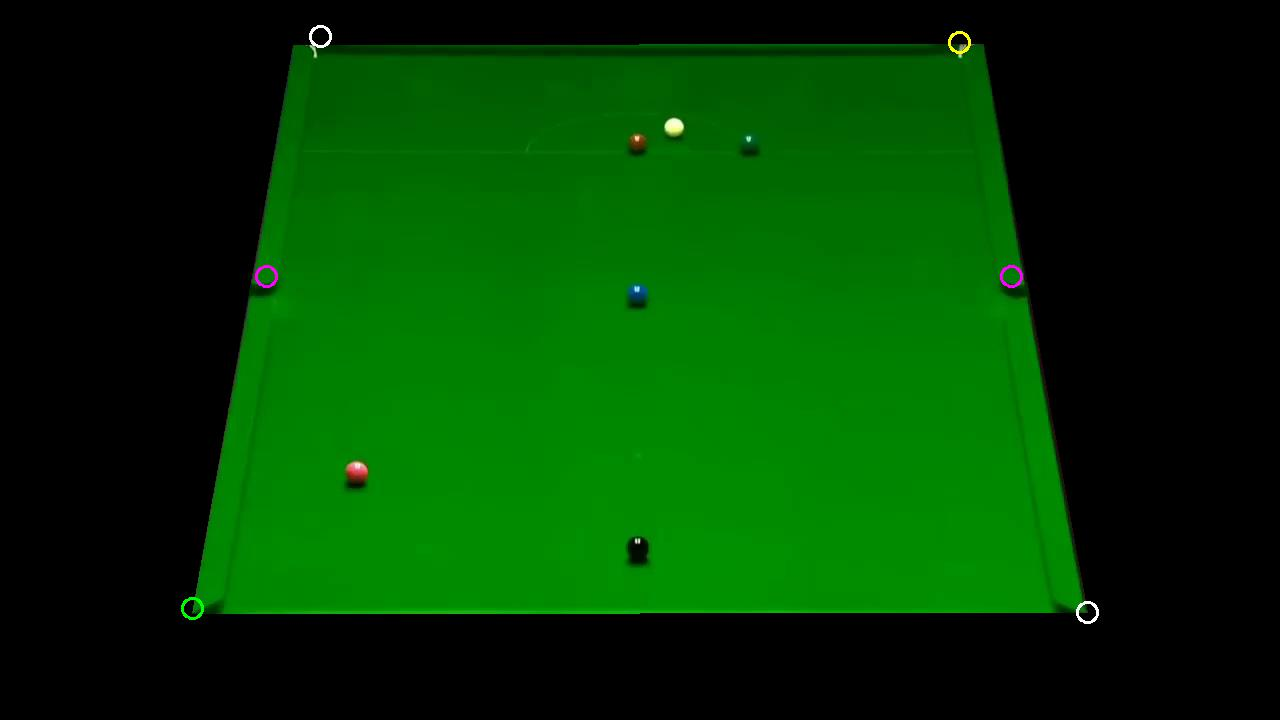

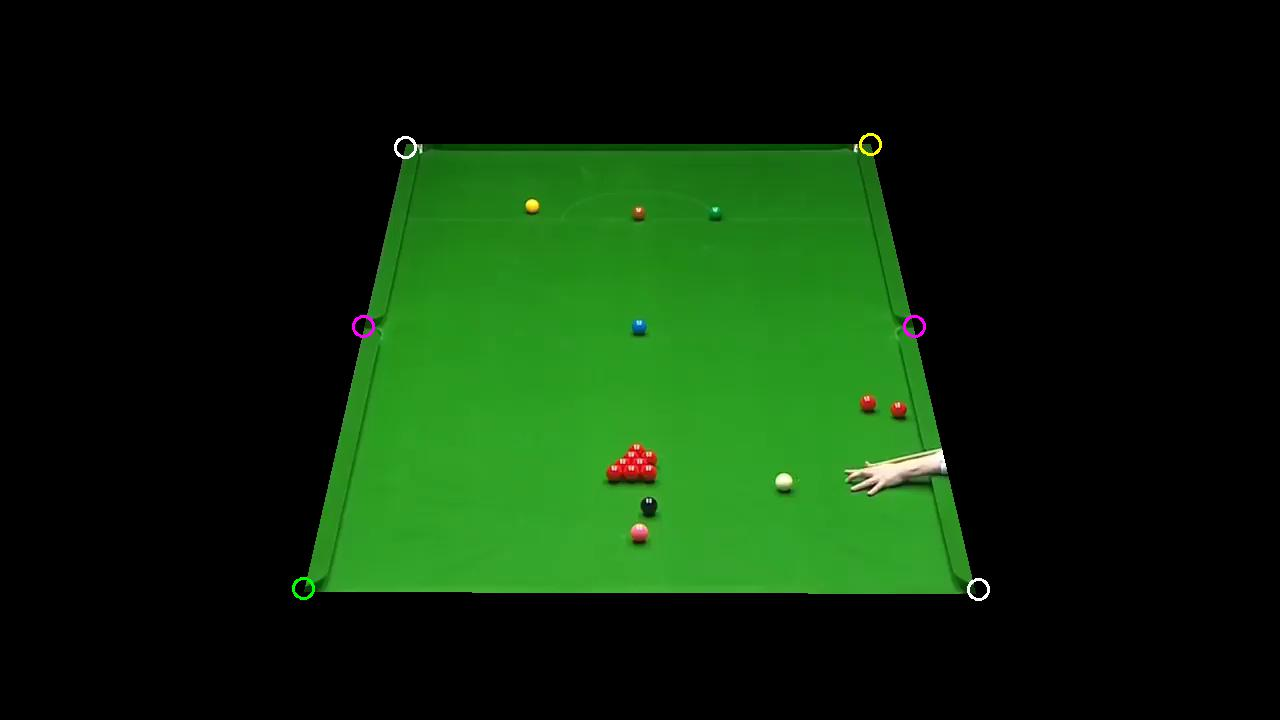

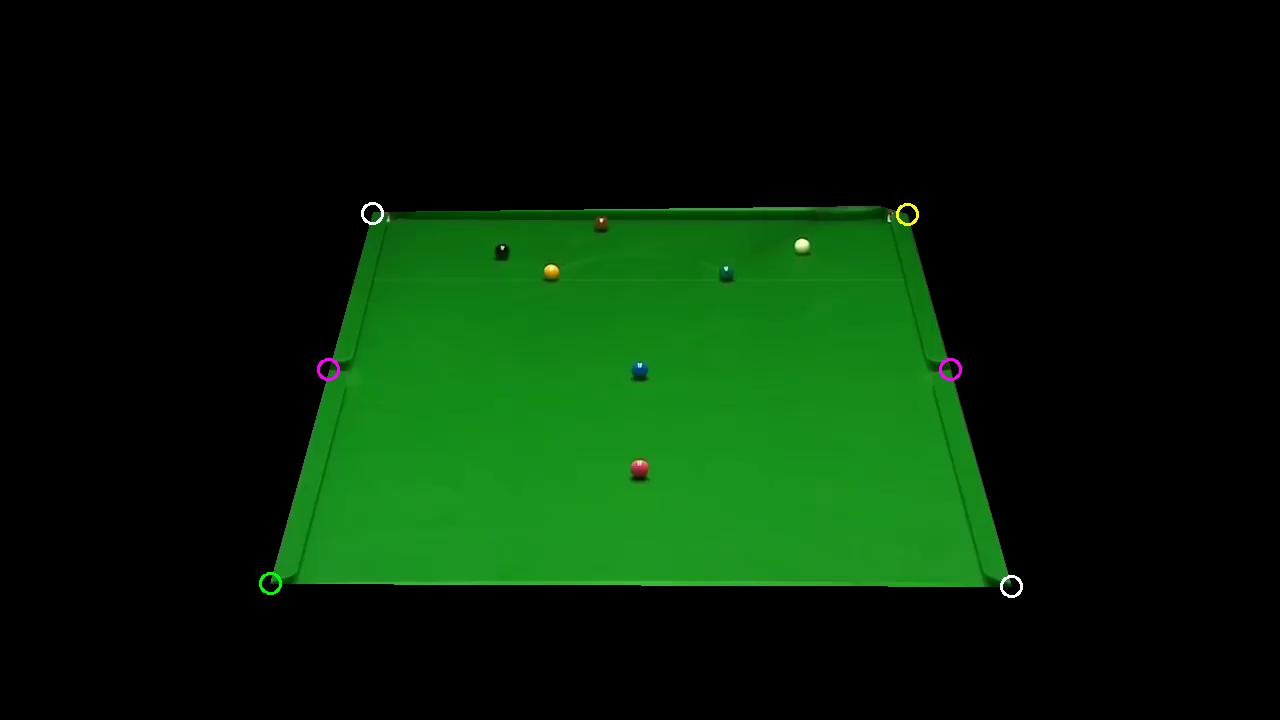

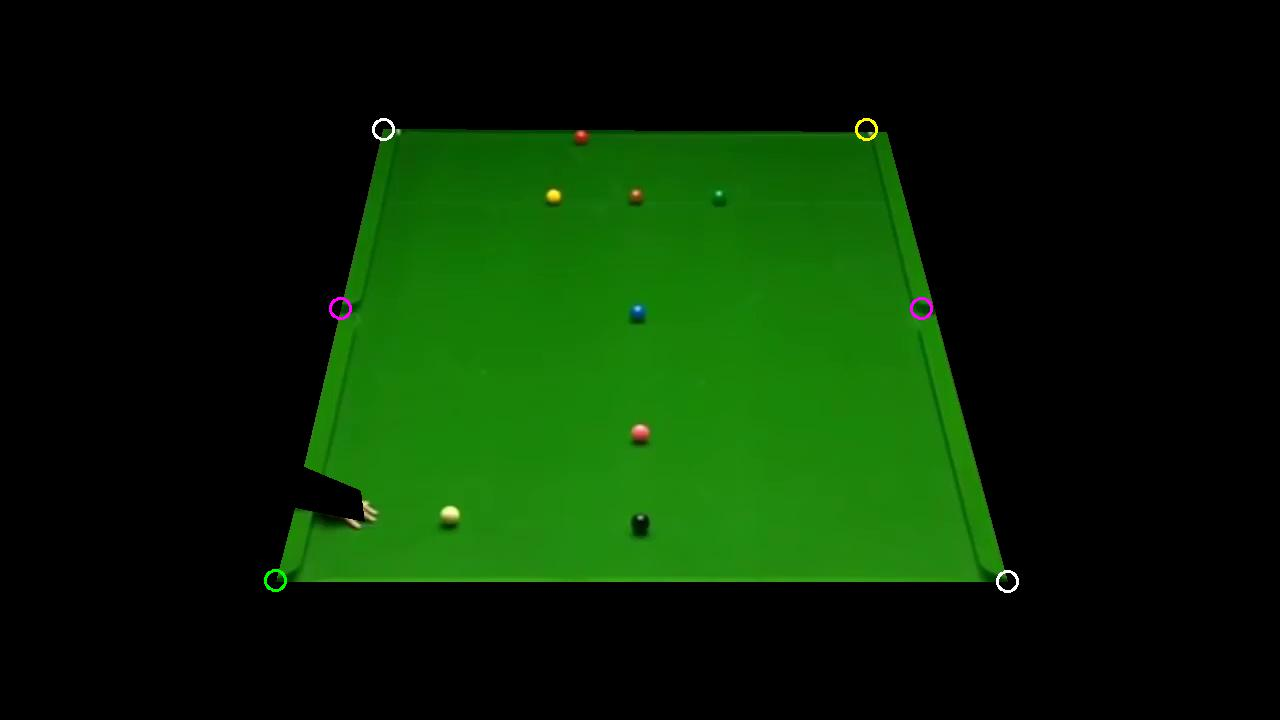

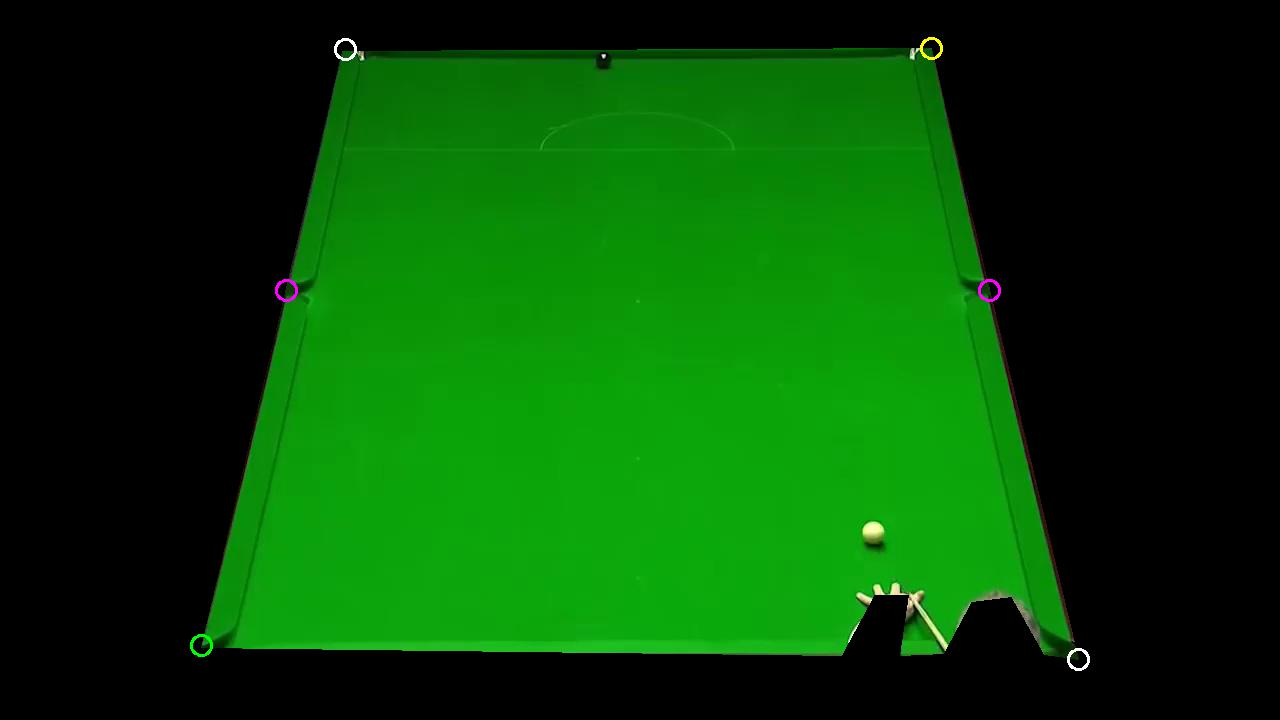

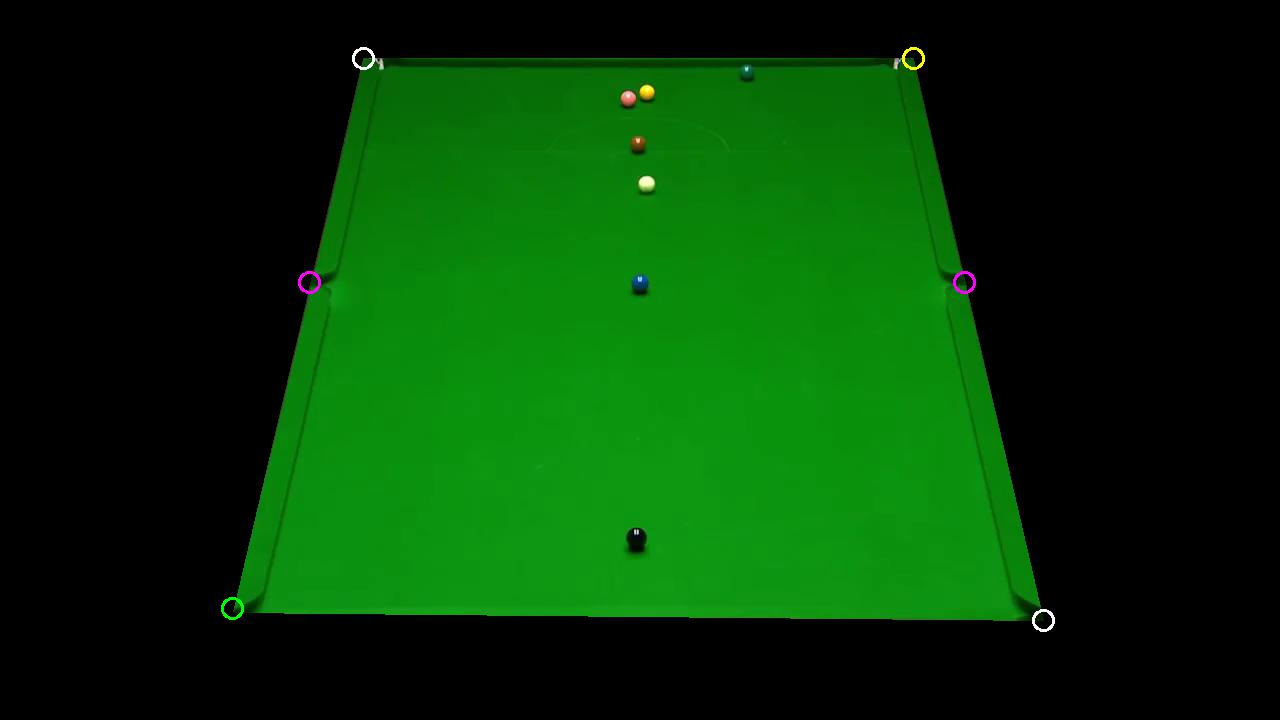

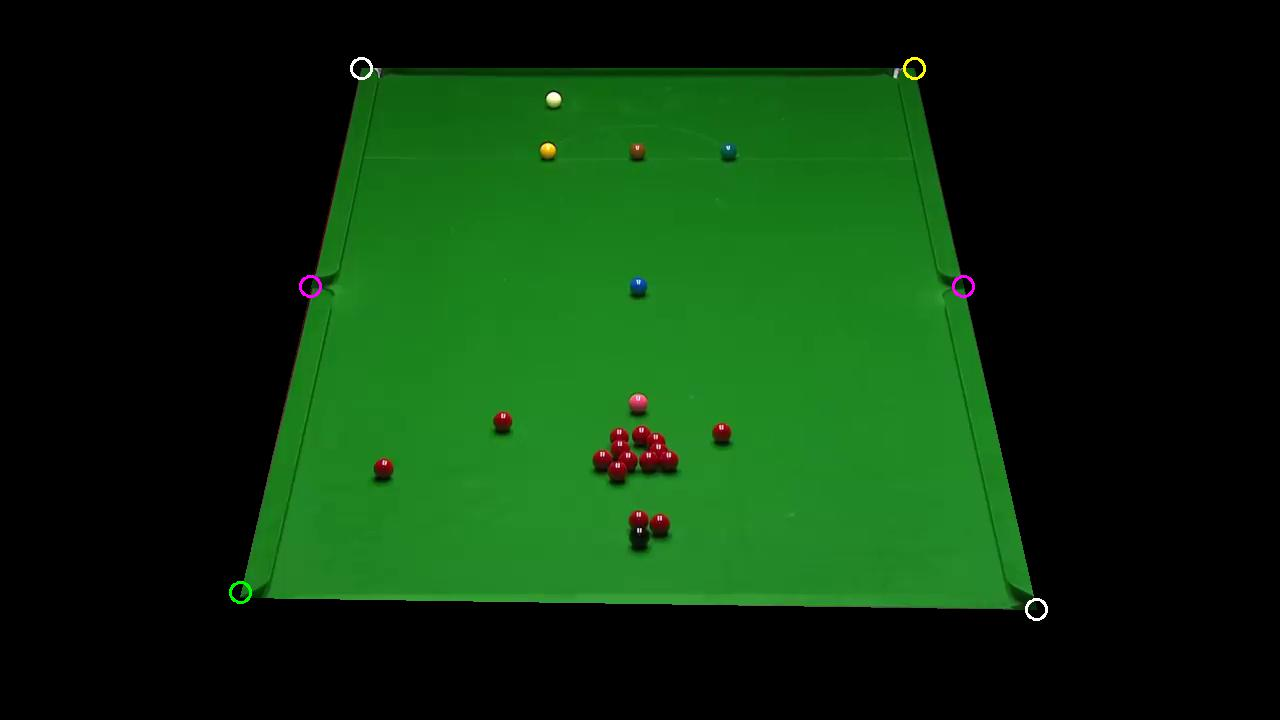

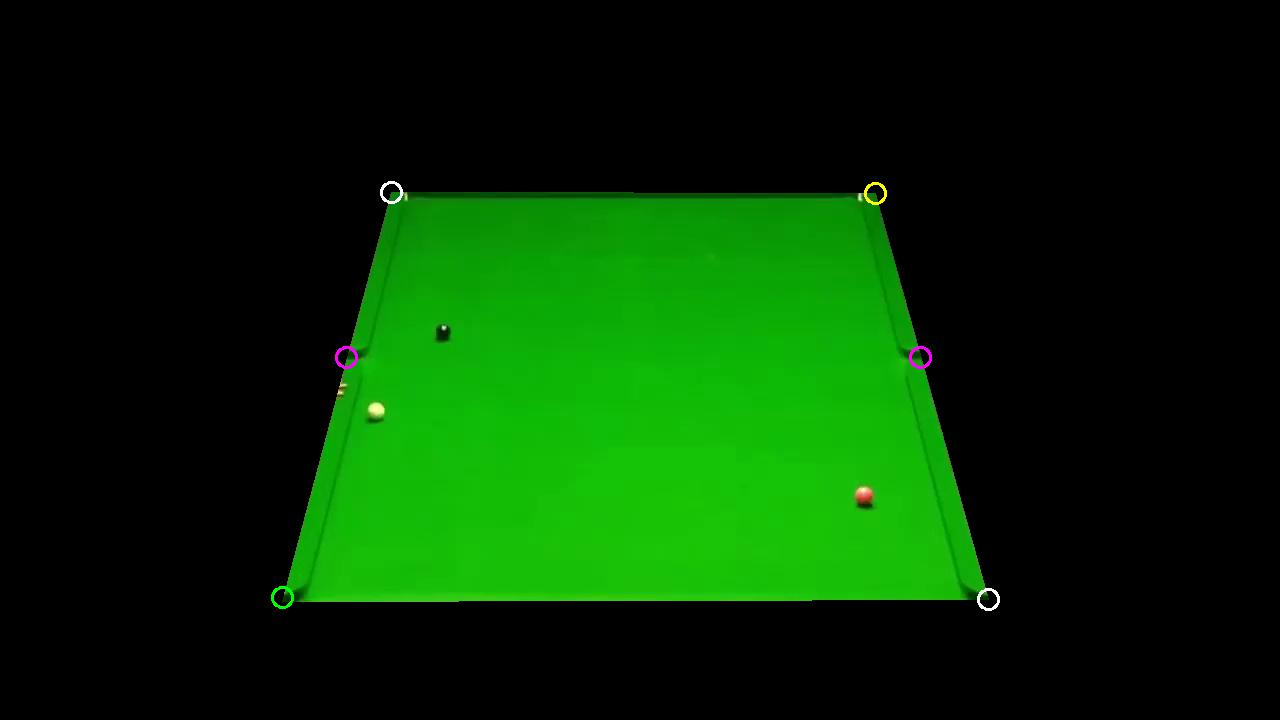

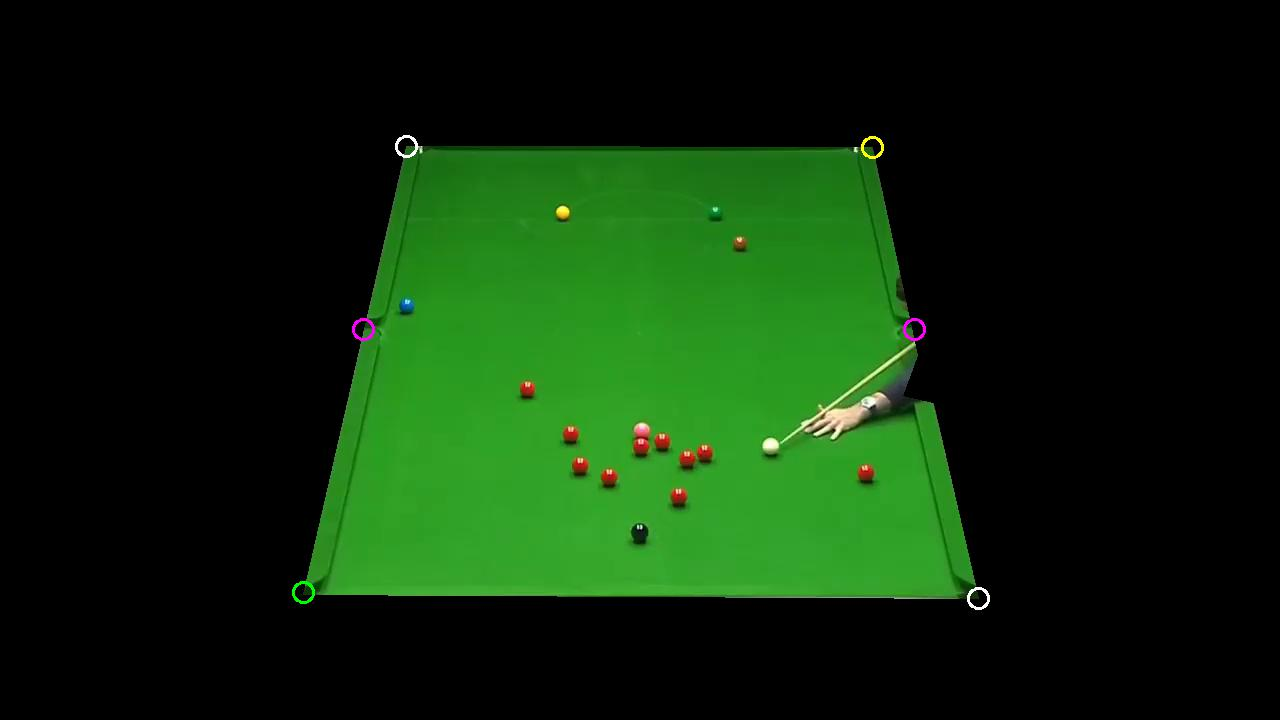

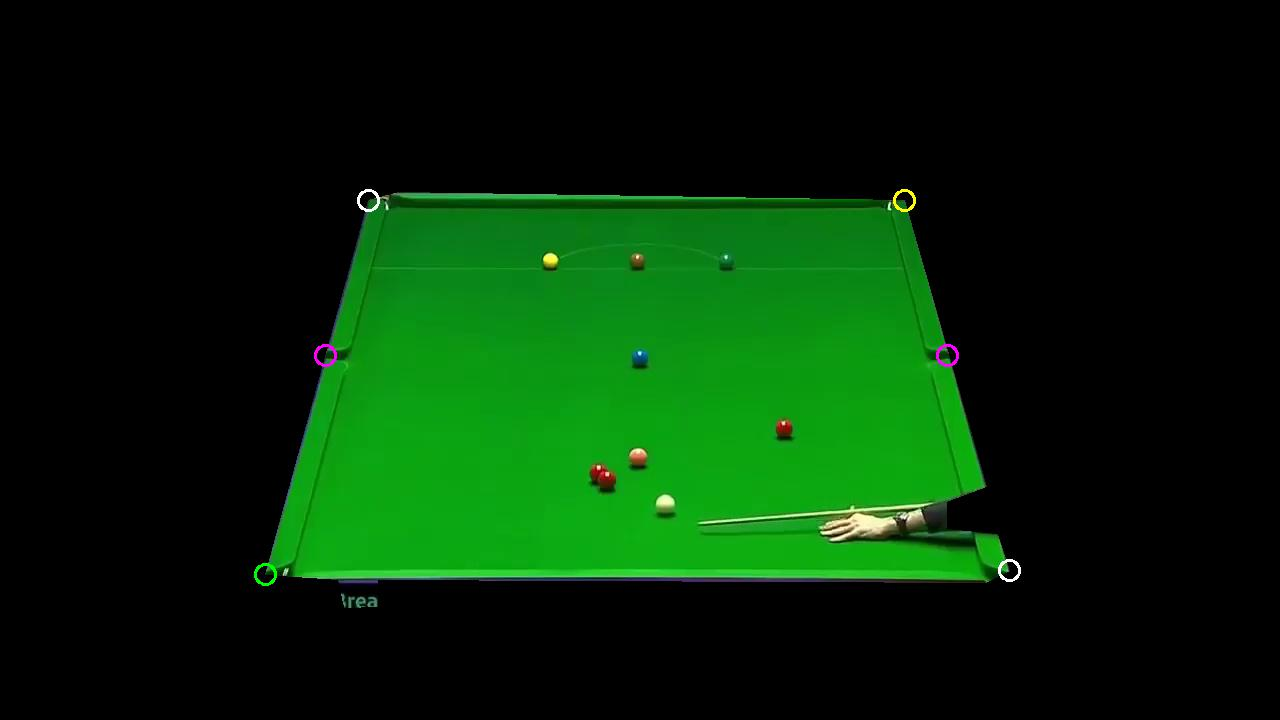

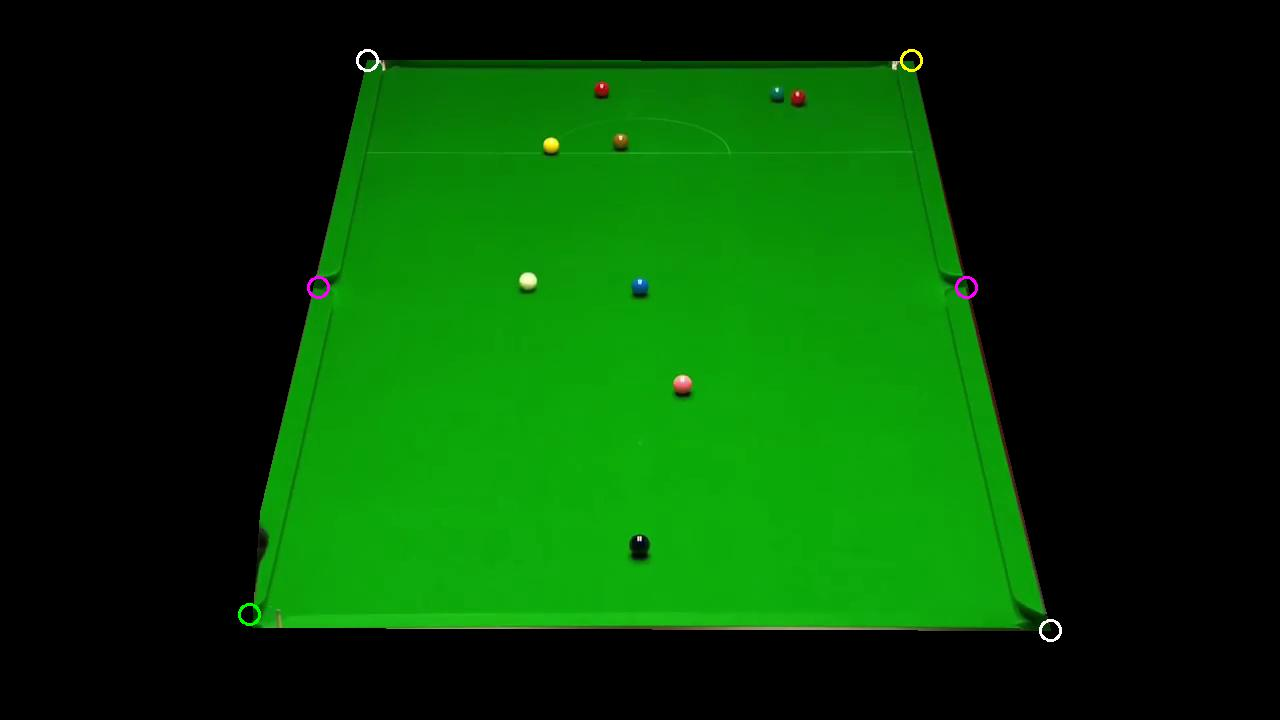

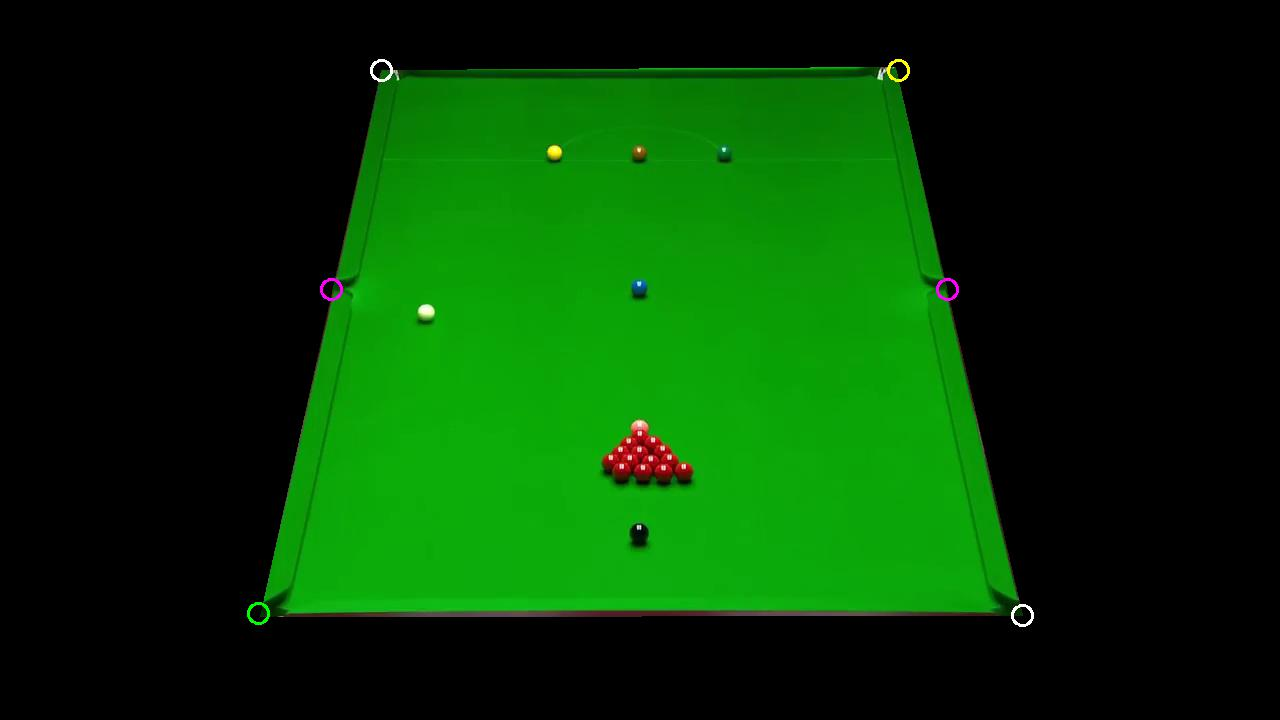

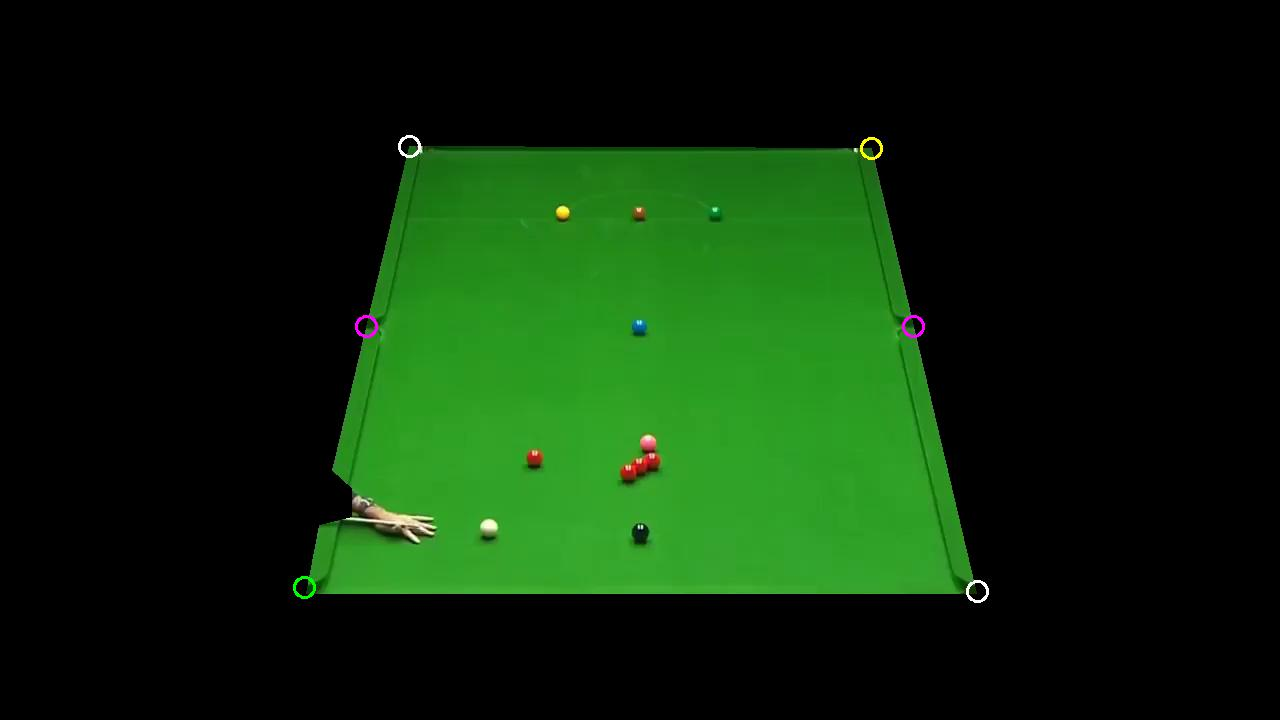

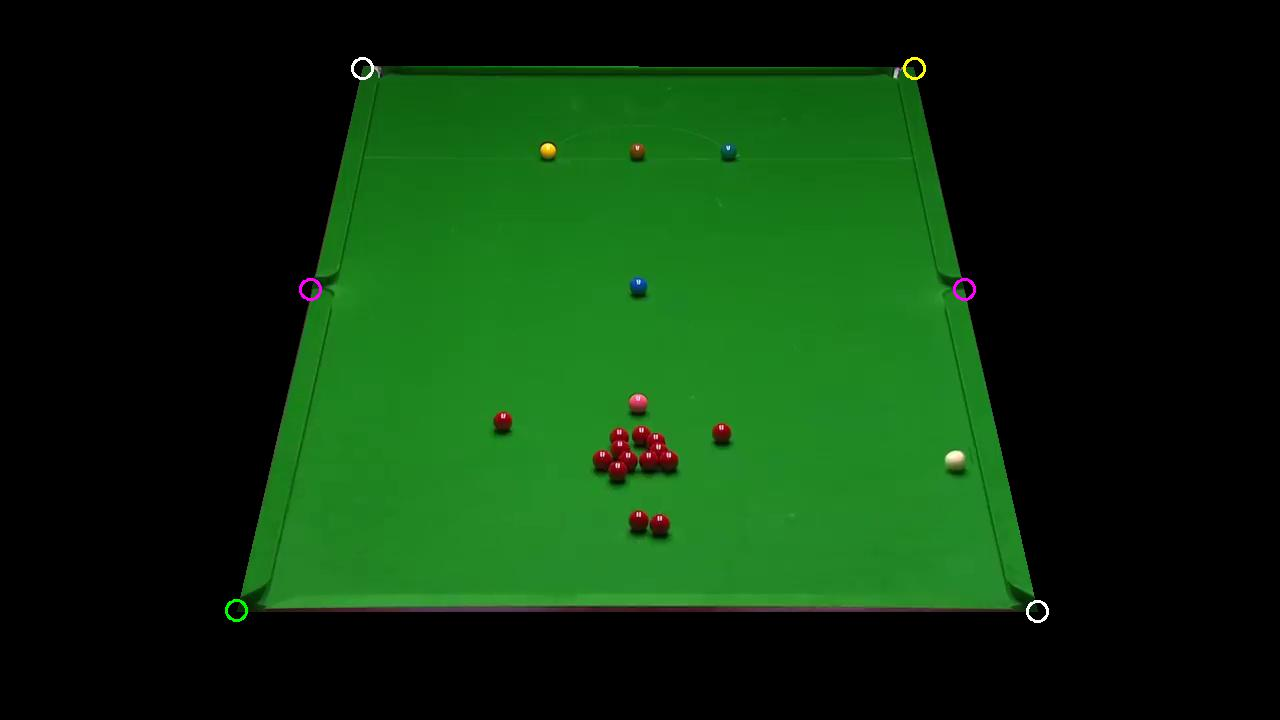

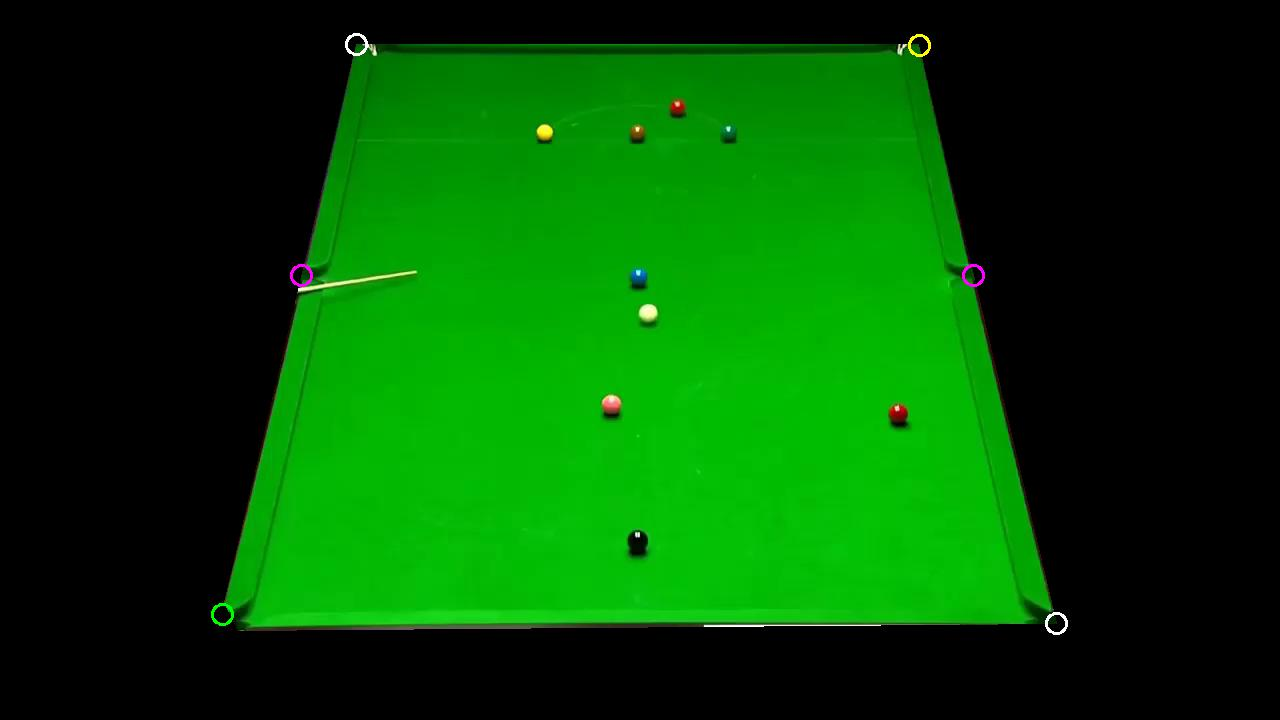

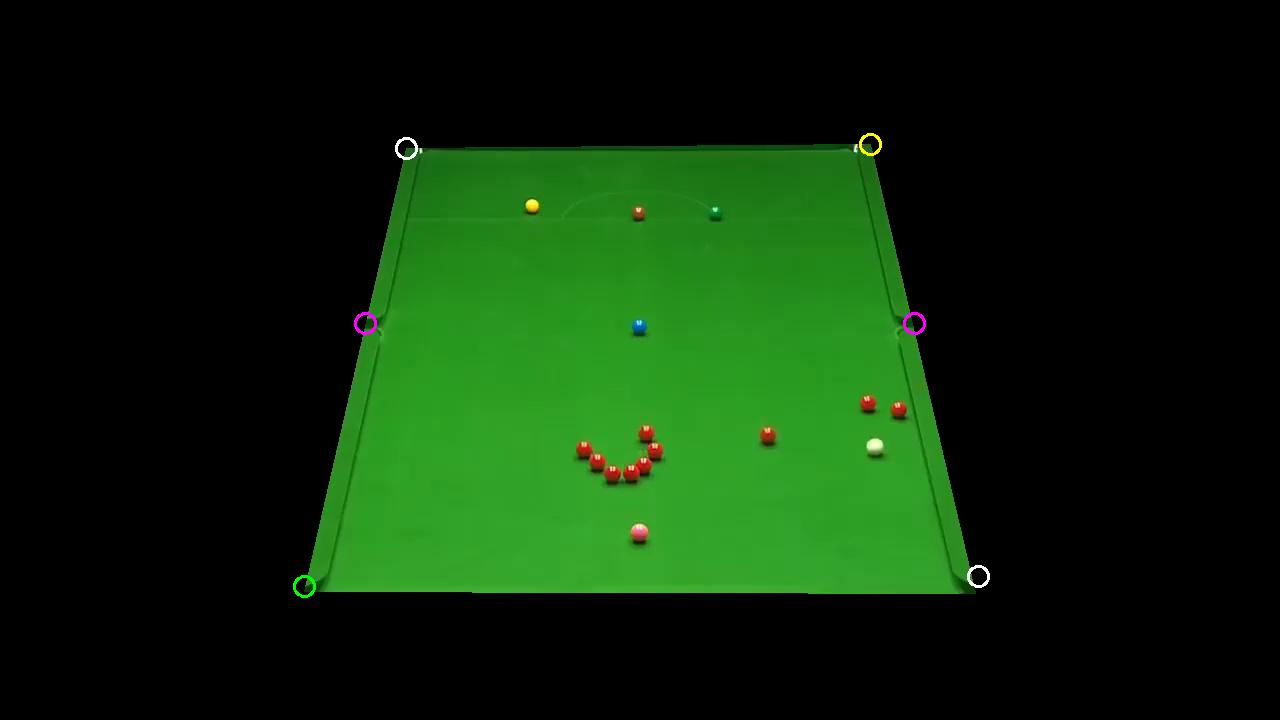

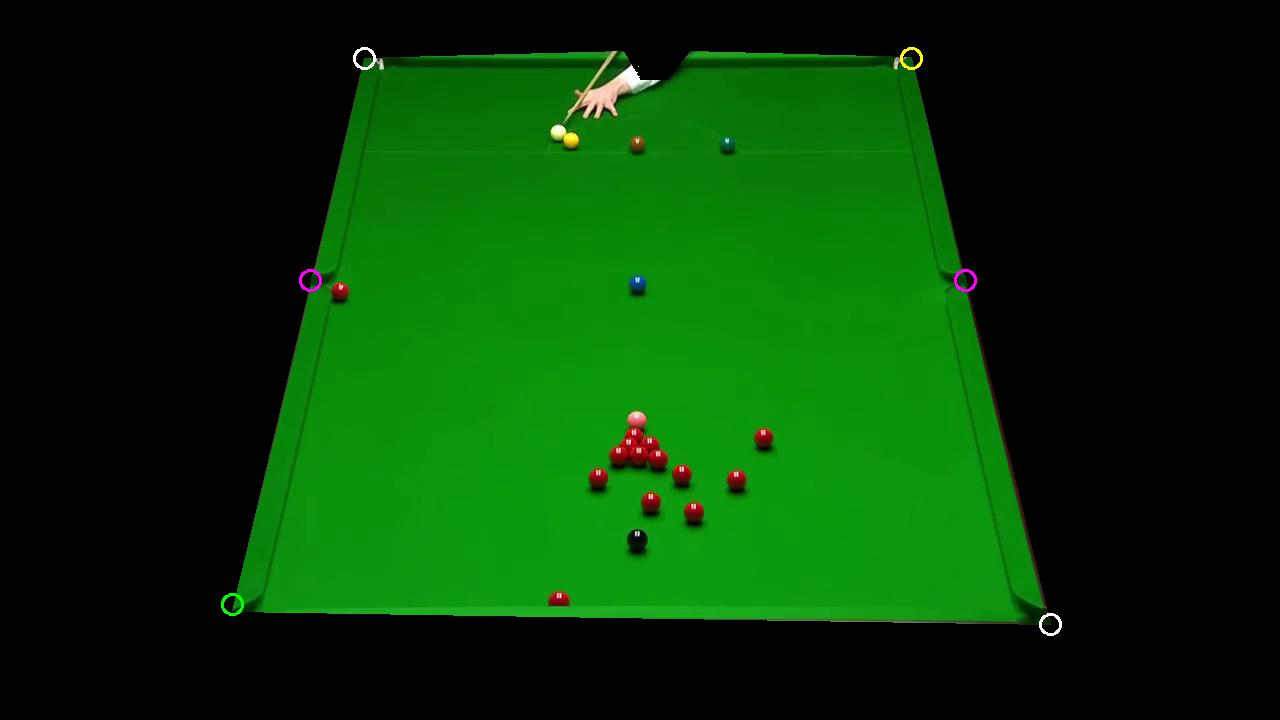

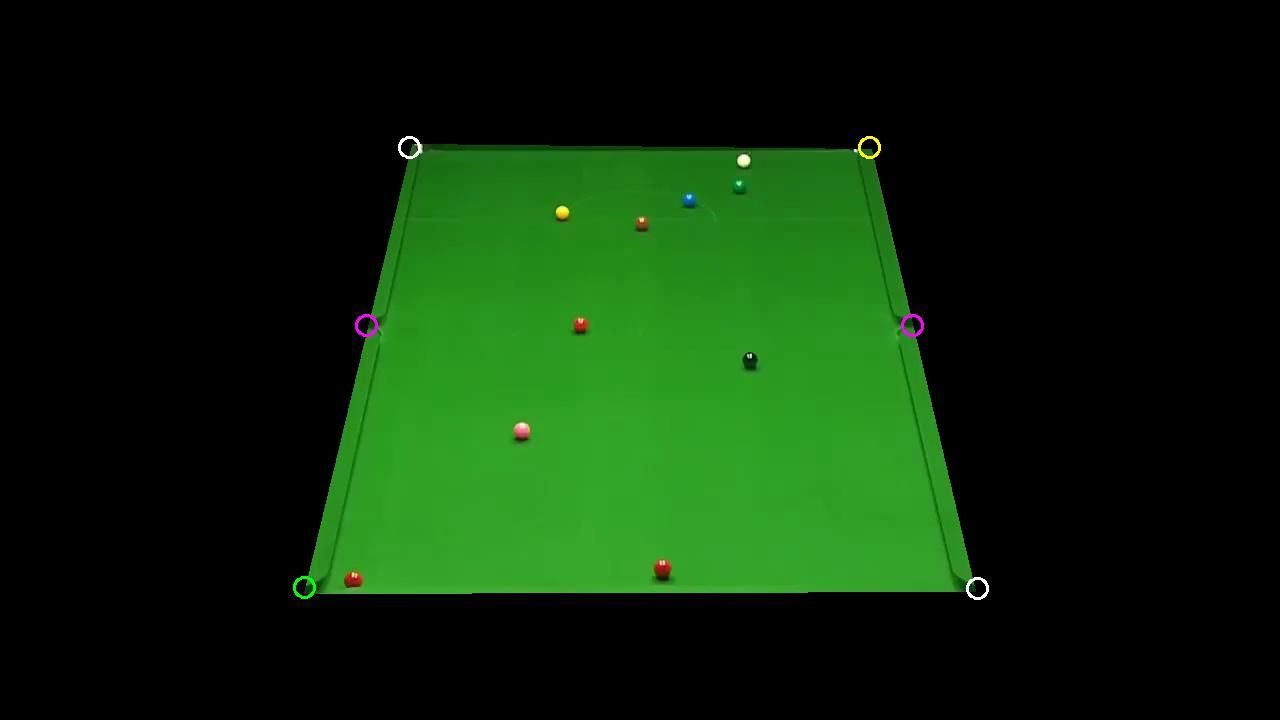

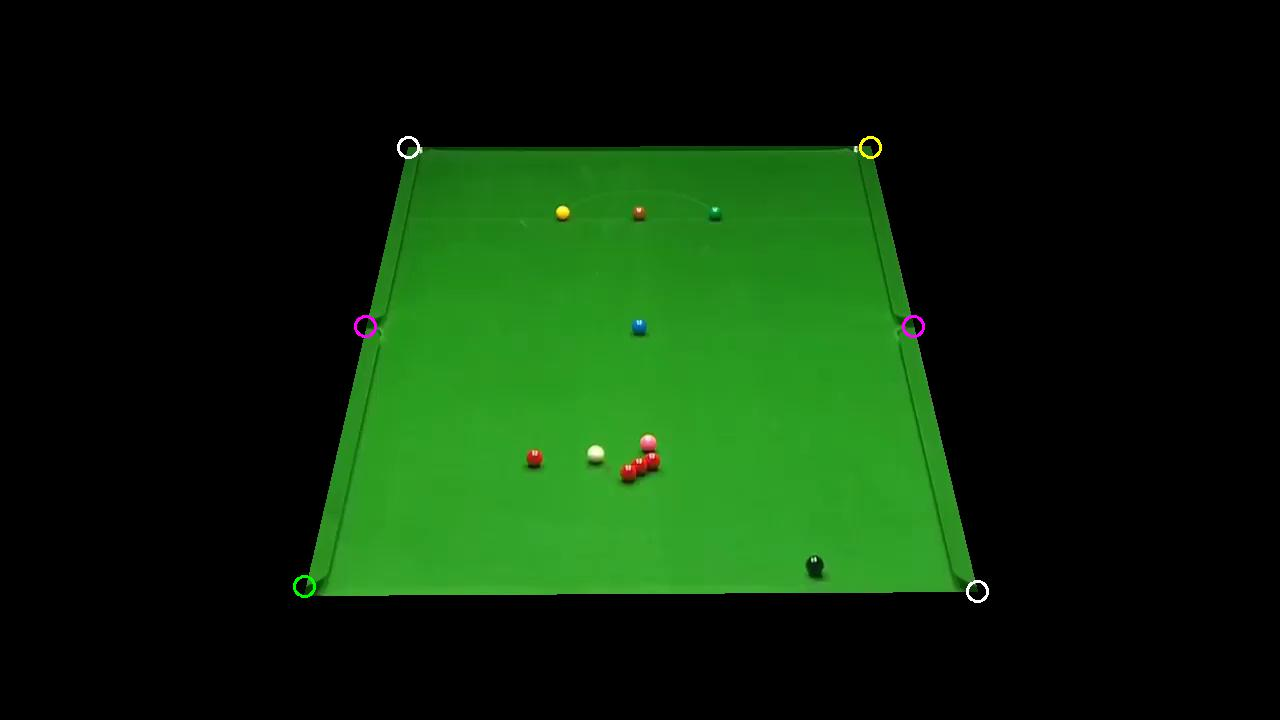

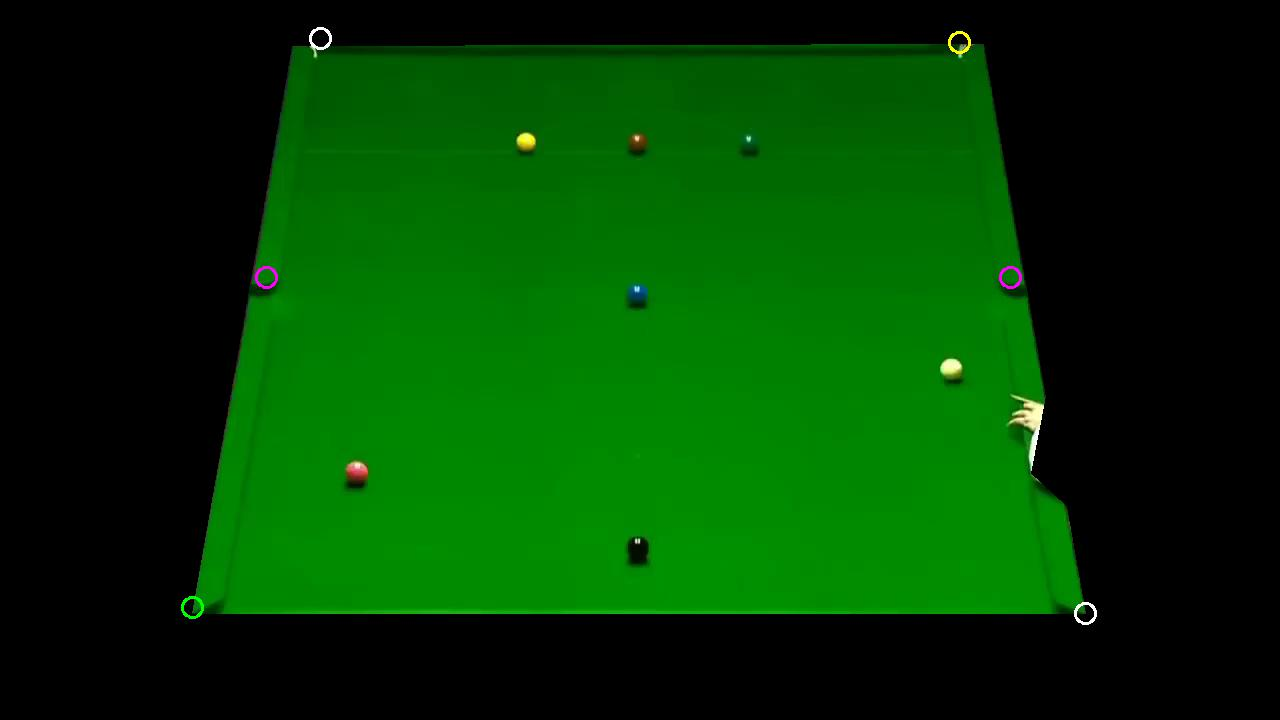

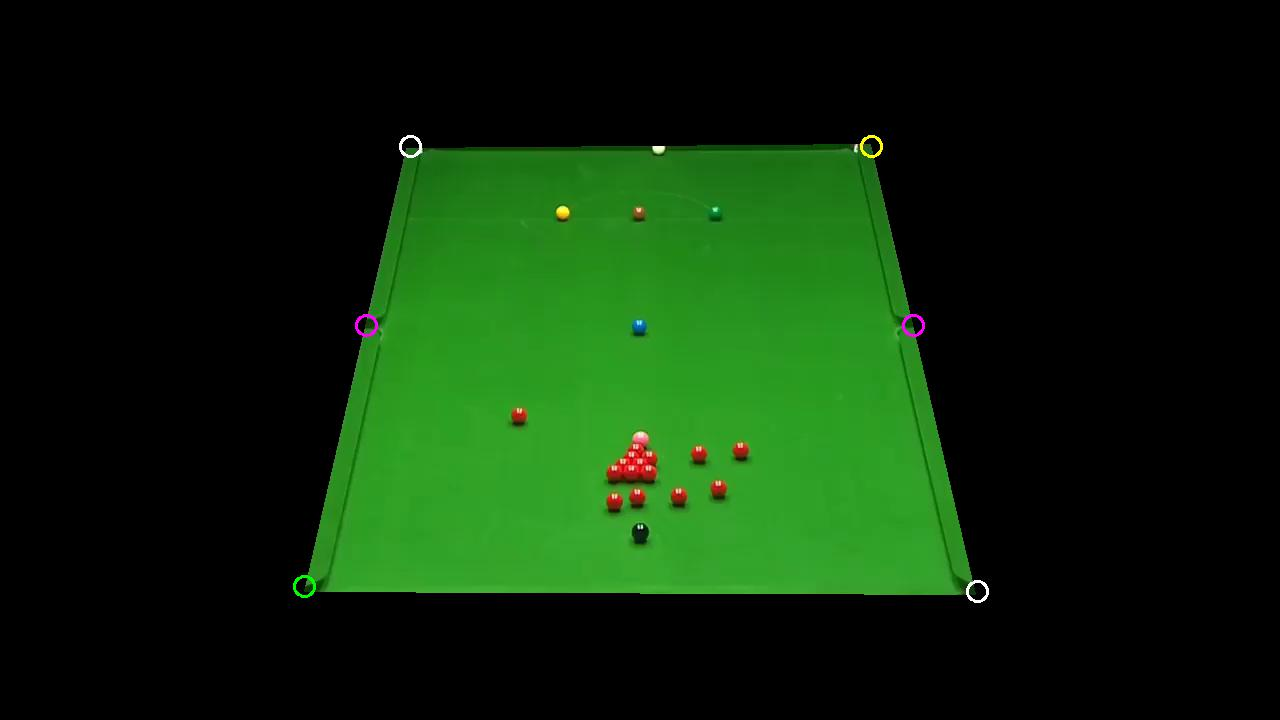

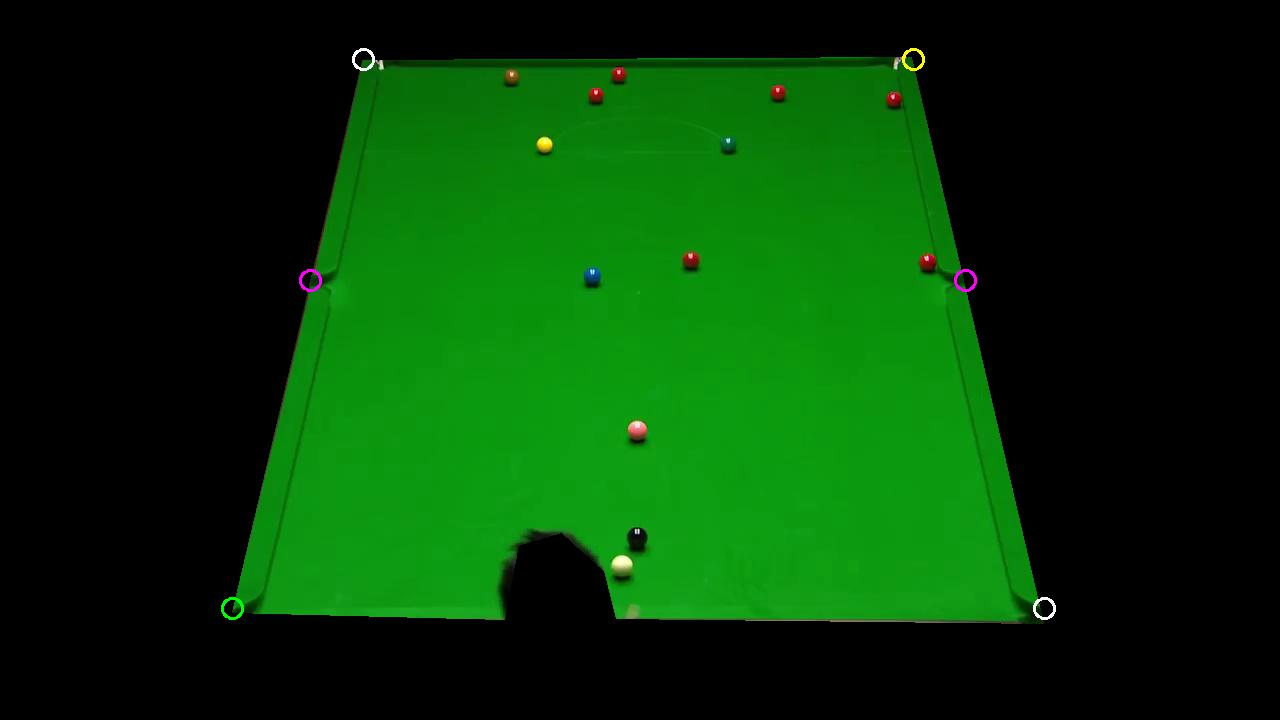

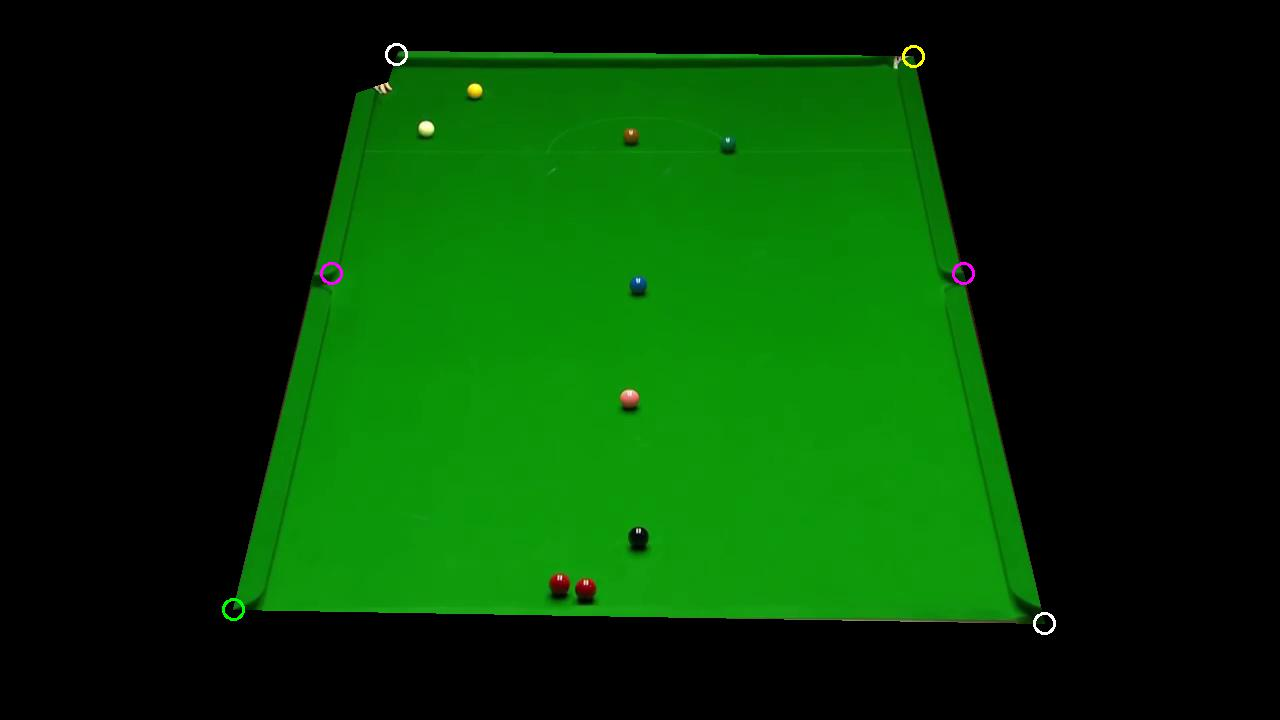

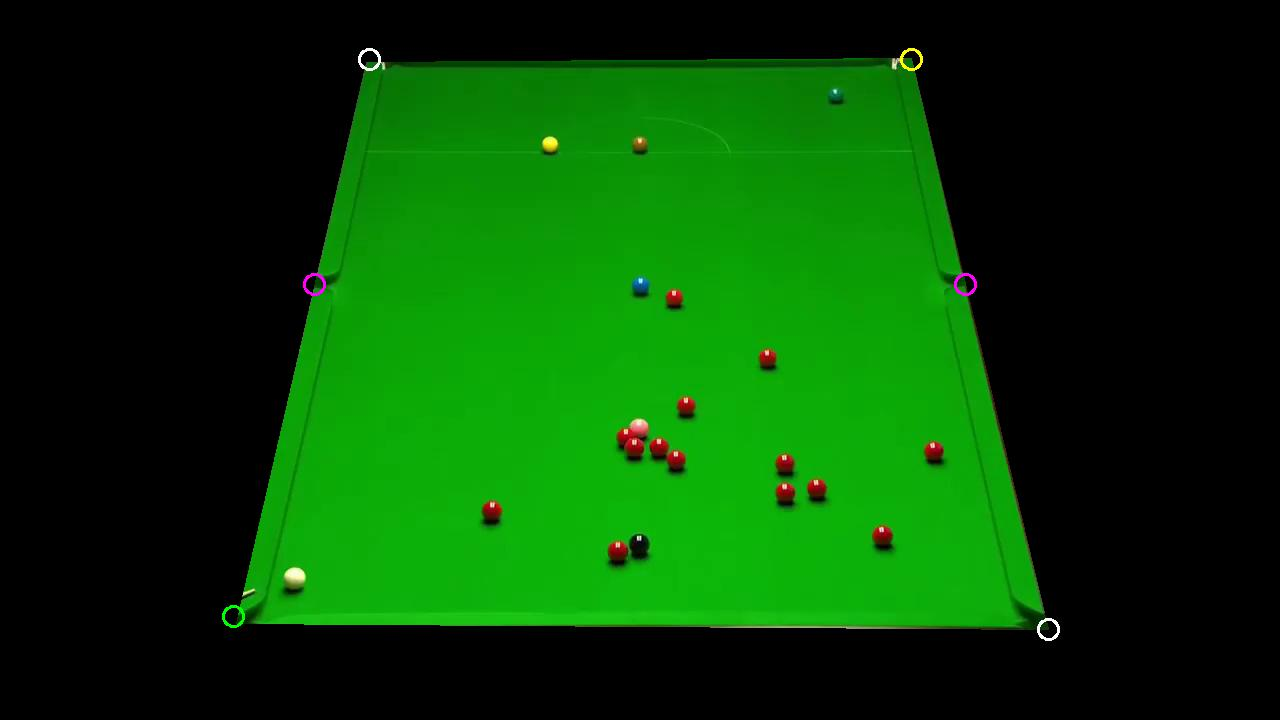

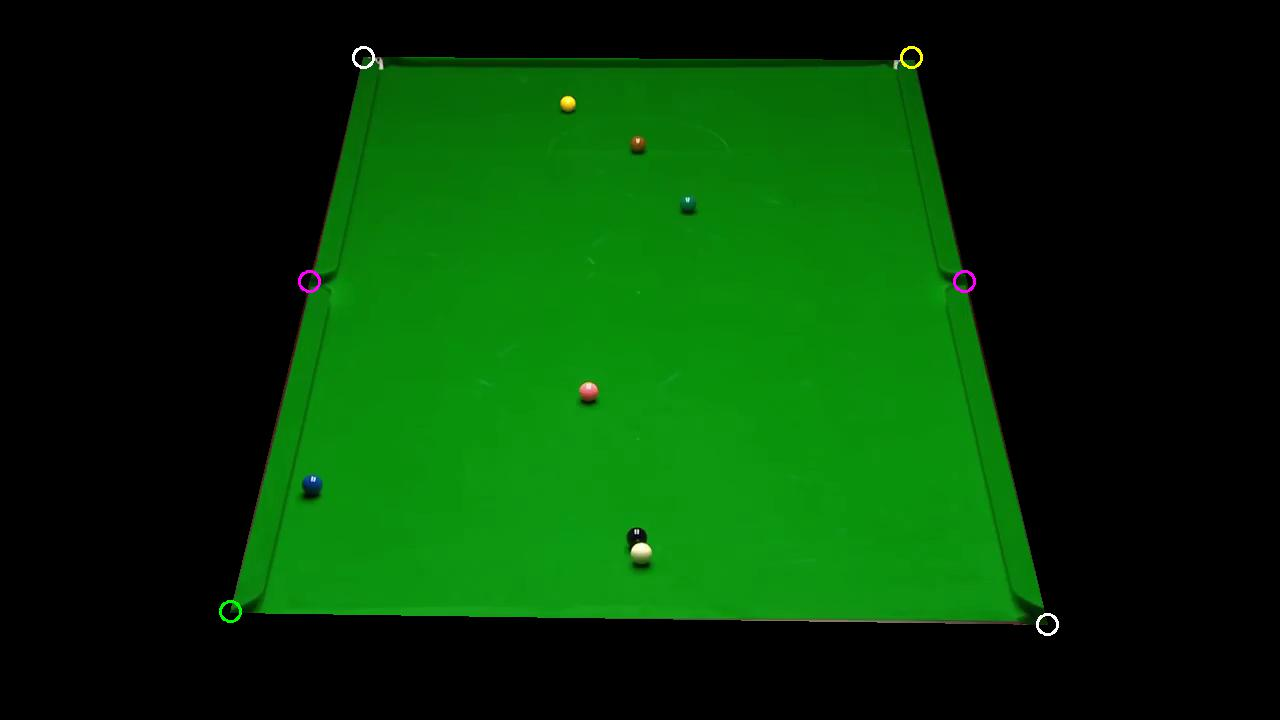

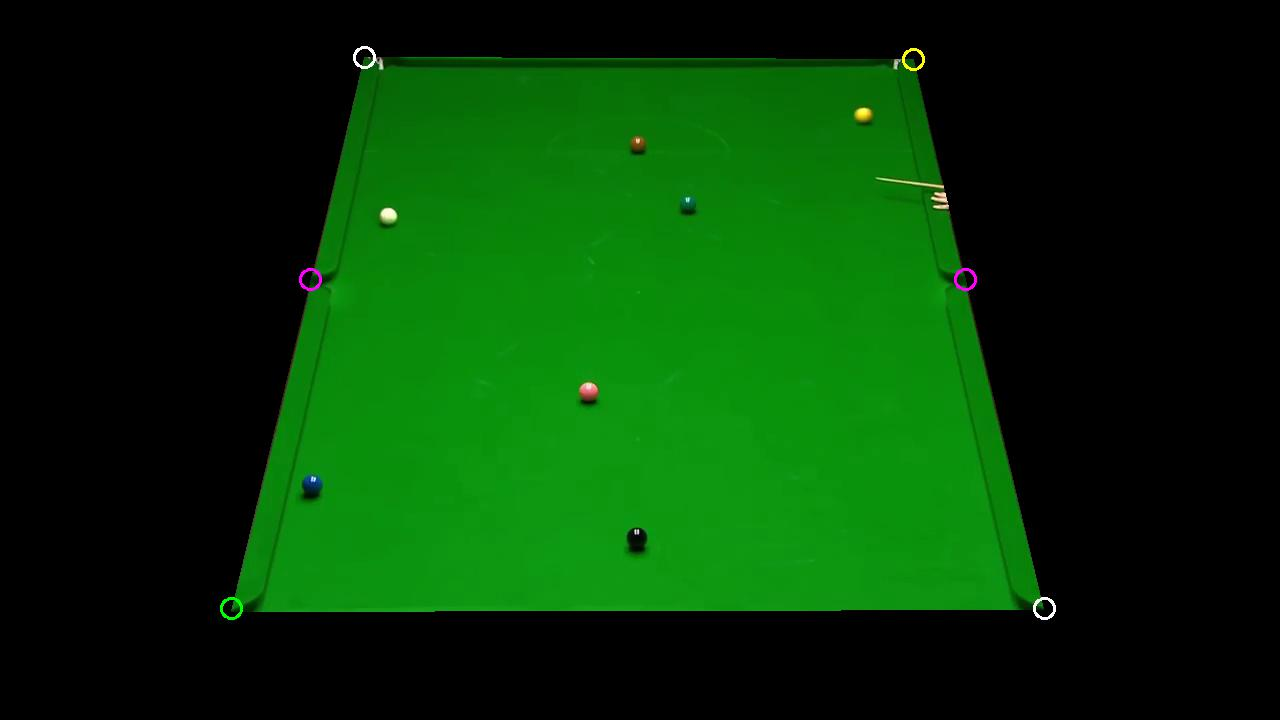

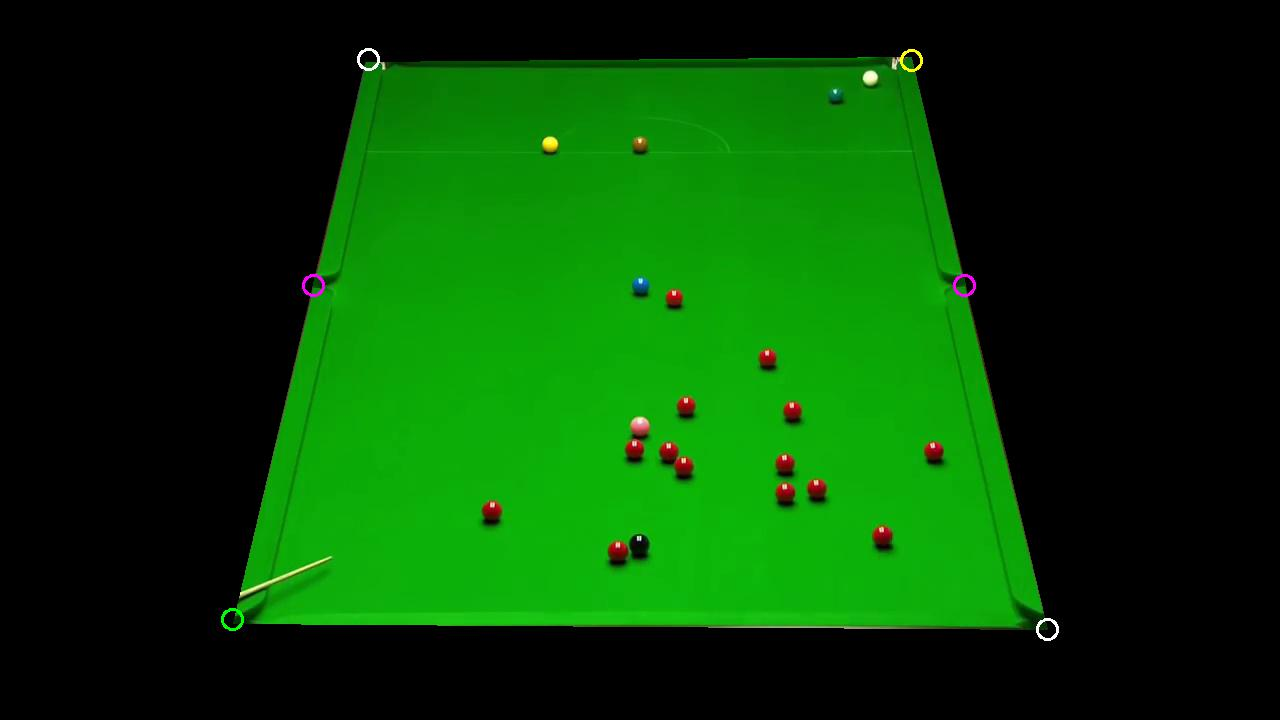

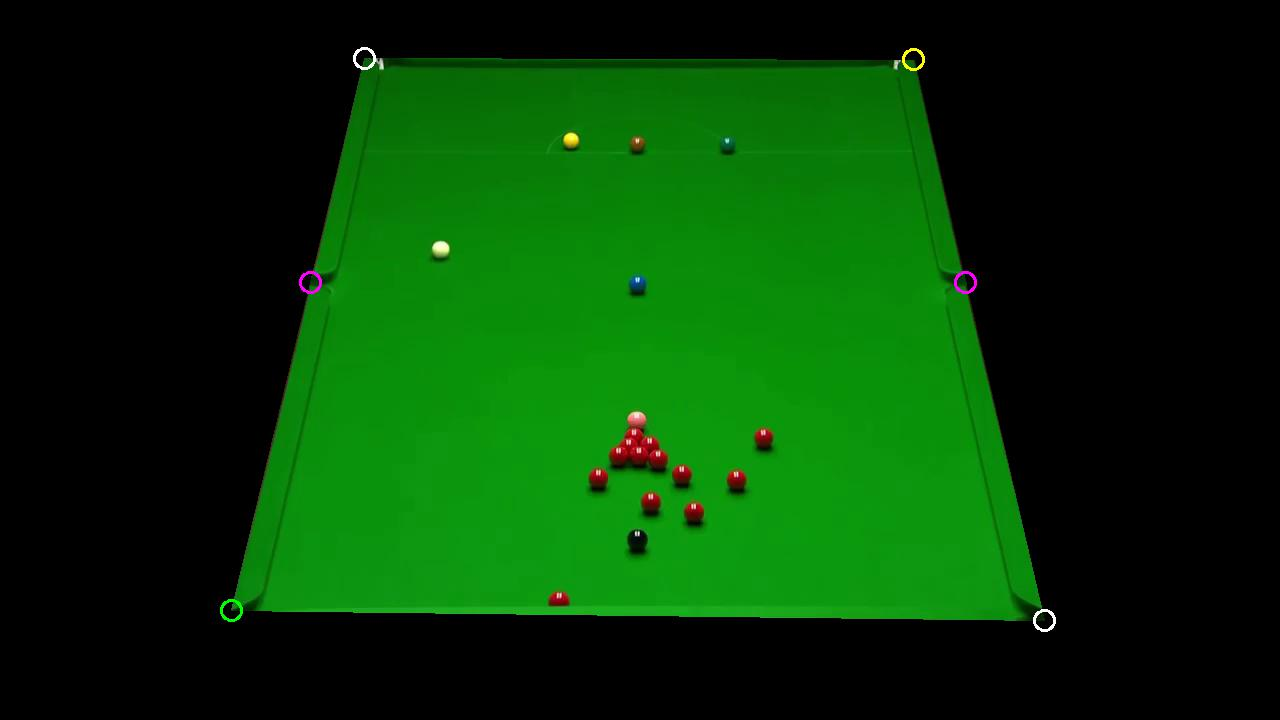

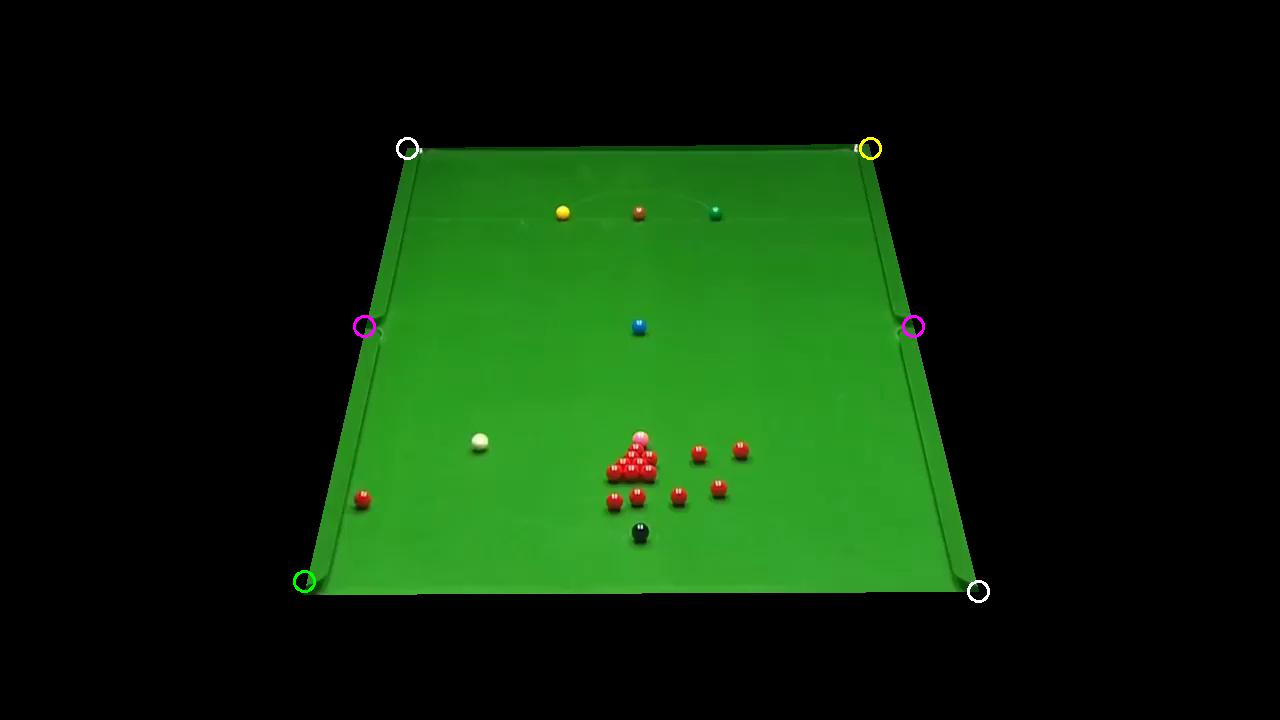

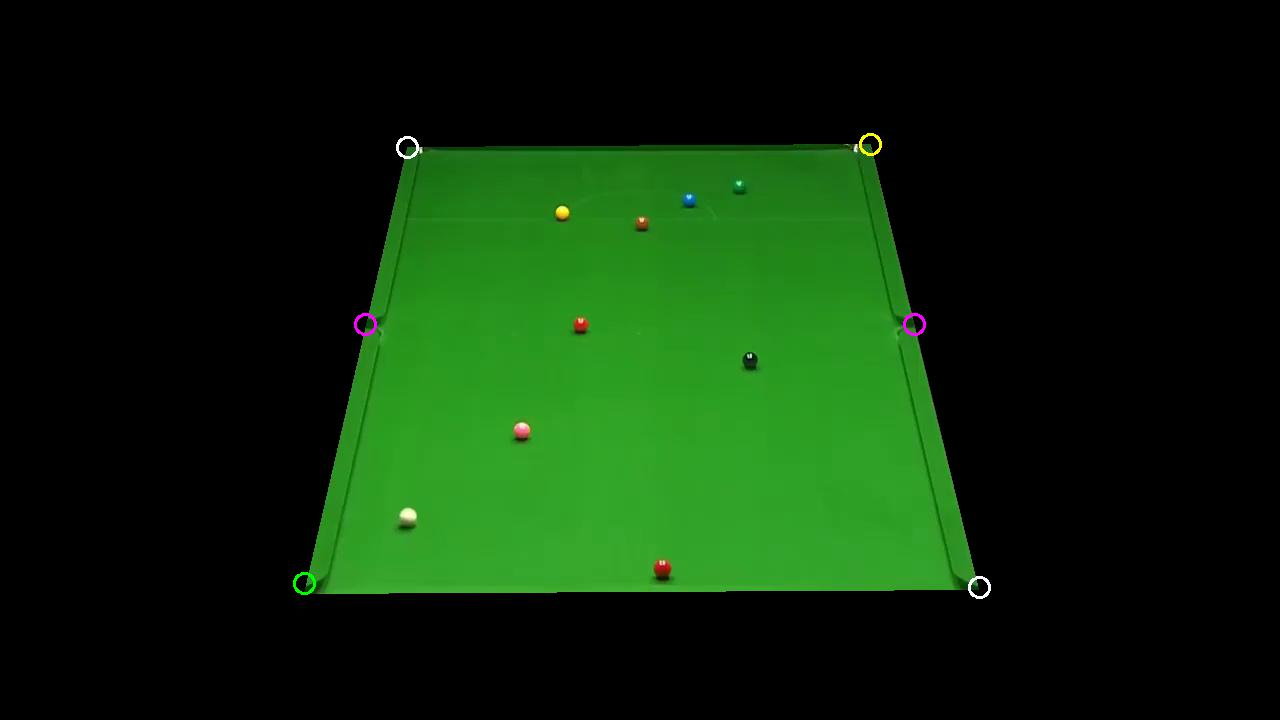

In [634]:
for i in range(0, len(task1)):
    img = read_image(i, task1, 1)
    contour = find_table(img)
    show_image(contour)

In [635]:
def open_video(path):
    cap = cv.VideoCapture(path)
    
    if cap.isOpened() == False: 
        print("Error opening video stream or file") 
    # Display the video
    current_frame = 0
    max_number_of_frame_to_run = 750

    while cap.isOpened(): 

        ret, frame = cap.read() # Read the frame
        
        if ret is True:
            current_frame = current_frame + 1 
            cv.imshow("Frame", frame)

            if current_frame > max_number_of_frame_to_run:
                break

            if cv.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break

    # after playing the video, release the video capture    
    cap.release()
    # close all the frames
    cv.destroyAllWindows()

def write_video(path):
    # We are going to write the same video 
    frames = read_frames(path)
    # here we have the extensions and the fourcc for each of it
    video_extension_and_fourcc_dict = {'avi': cv.VideoWriter_fourcc('M', 'J', 'P', 'G'),
                                       'mp4': 0x7634706d}   

    # We need to create a VideoWriter object. 
    # First, we should specify the output file name with its format (eg: 1_fps_1.mp4). 
    # we should specify the FourCC code and the number of frames per second (FPS). 
    # Lastly, the frame size should be passed (width, height).

    video_output_name = "Modified/Task2/" + path.split("/")[-1].split('.')[-2] + "_modified.mp4"
    output_video = cv.VideoWriter(video_output_name, video_extension_and_fourcc_dict["mp4"], 30,
                                  (frames[0].shape[1], frames[0].shape[0]))

    num_frames = len(frames)
    # We know that the first video has 30 fps.
    for i in range(0, num_frames):
        output_video.write(frames[i]) # writing the frame

    # don't forget to release the video writer
    output_video.release()

In [636]:
def detect_circles(img):
    img = img.copy()
    image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    image = cv.medianBlur(image, 5)
    circles = cv.HoughCircles(image,cv.HOUGH_GRADIENT,1,10,
                            param1=50,param2=12,minRadius=5,maxRadius=15)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
    
        for i in circles[0, :]:
            cv.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
            cv.circle(img,(i[0],i[1]),2,(0,0,255),3)

    return img

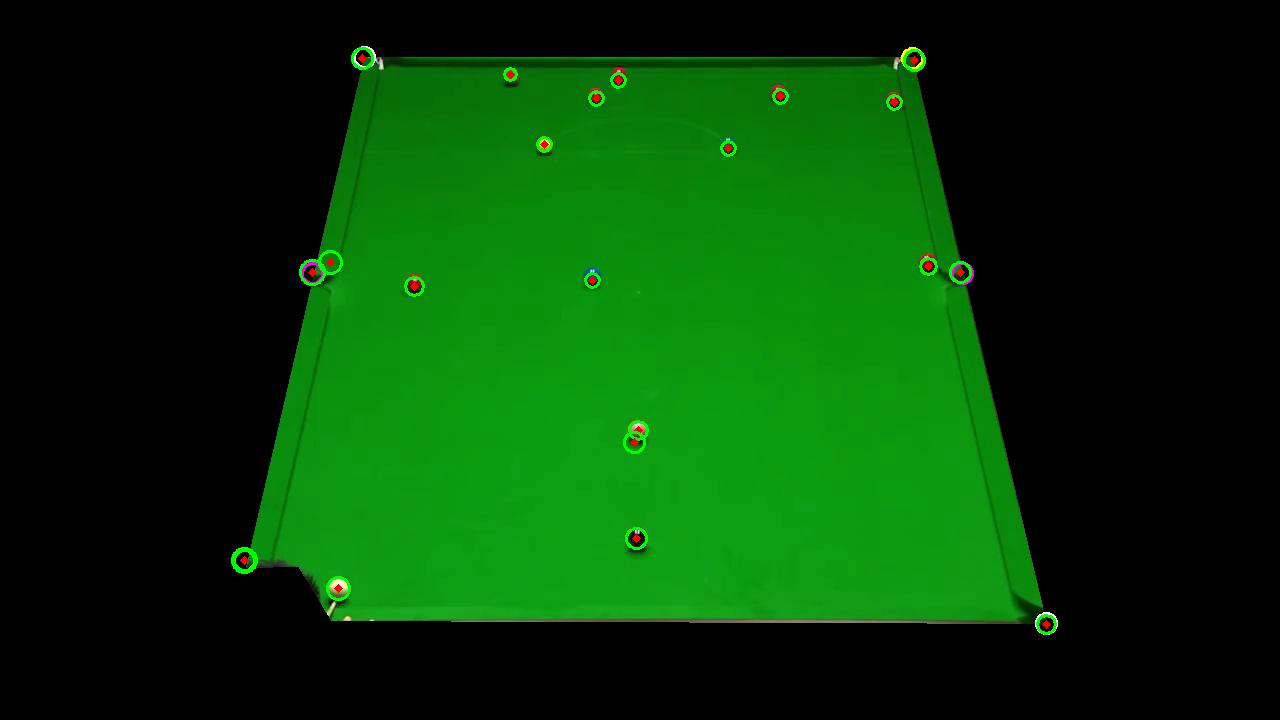

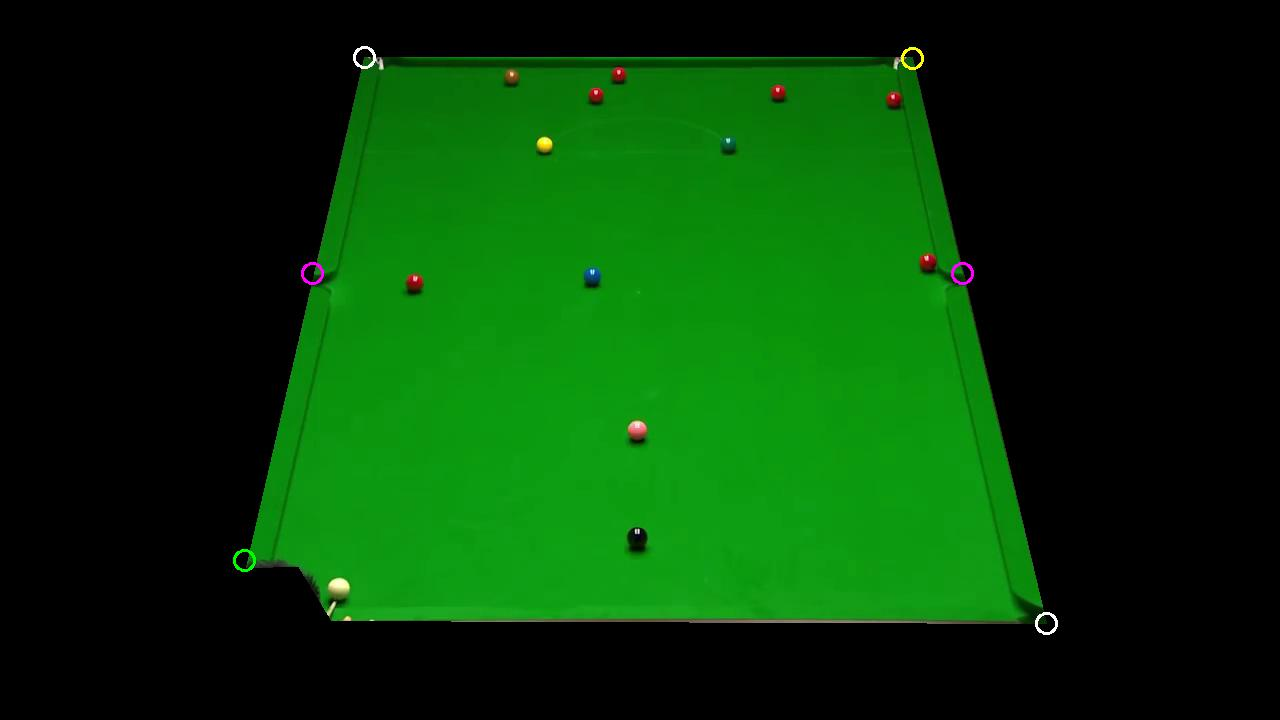

In [637]:
img1 = read_image(5, task1, 1)
img1 = find_table(img1)
img_circles = detect_circles(img1)
show_image(img_circles)
show_image(img1)

In [312]:
open_video(task2_modified[0])

In [638]:
print(task4)

['./training_data/Task4/11.mp4', './training_data/Task4/7.mp4', './training_data/Task4/25.mp4', './training_data/Task4/19.mp4', './training_data/Task4/4.mp4', './training_data/Task4/8.mp4', './training_data/Task4/21.mp4', './training_data/Task4/17.mp4', './training_data/Task4/6.mp4', './training_data/Task4/24.mp4', './training_data/Task4/22.mp4', './training_data/Task4/18.mp4', './training_data/Task4/1.mp4', './training_data/Task4/10.mp4', './training_data/Task4/5.mp4', './training_data/Task4/9.mp4', './training_data/Task4/20.mp4', './training_data/Task4/14.mp4', './training_data/Task4/16.mp4', './training_data/Task4/12.mp4', './training_data/Task4/15.mp4', './training_data/Task4/23.mp4', './training_data/Task4/3.mp4', './training_data/Task4/13.mp4', './training_data/Task4/2.mp4']


In [640]:
# print(task2[0].split("/")[-1].split('.')[-2])
write_video(task2[0])

In [3]:
# task 1
# read the templates balls
templates = []
base_folder_matching = 'training_data/template_matching/Task1'
images_names = glob.glob(os.path.join(base_folder_matching, "*.jpg")) 
    
color_dict = {0: "black",
              1: "blue",
              2: "brown",
              3: "green",
              4: "pink",
              5: "red",
              6: "white",
              7: "yellow"}